# ACM40960

### 1. Load relevant libraries

Import all relevant libraries and functions into the notebook.

In [970]:
import pandas as pd
from pandas import DataFrame
import glob
import math
import numpy as np
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import linear_model
import mord
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from scipy.stats import probplot
from scipy.stats import norm
from scipy.stats import boxcox
from scipy.special import boxcox as spboxcox
from scipy.special import inv_boxcox
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as qda
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from collections import Counter
import random
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier as boost
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier as adaboost
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression as logreg
from random import shuffle
from matplotlib.lines import Line2D

### 2. Load the data

Load the data from all csv files in the Data folder, and merge into a single data frame

In [971]:
# function that gets all csv files in the given path, extracts the specified columns, and returns a
# single dataframe combining the data from all of the files
def load_csv_files(path, columns):
    # Get file names of all csv files in the specified path
    filenames = sorted(glob.glob(path + "/*.csv"))
    # create empty list to store data frames from each csv file
    li = []

    # loop through all csv file names
    for filename in filenames:
        # read in specified columns for current file, drop rows with NAs
        df = pd.read_csv(filename, usecols=columns).dropna()
        # append dataframe from current EPL year to list
        li.append(df)

    # combine all data frames in list into a single data frame, and reset row indices
    df = pd.concat(li, axis=0)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [972]:
# get EPL data from csv files in the 'Data' folder (get 'HomeTeam', 'AwayTeam' and 'FTR'data)
EPL = load_csv_files('Data/', ['HomeTeam', 'AwayTeam', 'FTR'])

In [973]:
EPL

,HomeTeam,AwayTeam,FTR
0,Aston Villa,Man United,H
1,Blackburn,QPR,H
2,Chelsea,Everton,D
3,Liverpool,Sheffield Weds,H
4,Man City,Tottenham,D
...,...,...,...
9495,Leicester,Man United,A
9496,Man City,Norwich,H
9497,Newcastle,Liverpool,A
9498,Southampton,Sheffield United,H


### 4. Data Preparation - Calculate known metrics from the data

Calculate total number of points earned by each team each in the current season, and results obtained for each team in each fixture of each season. 

Then add new columns to EPL data frame for both home and away teams, containing:

- proportion of total number of points achieved in the current season,
- proportion of total number of points achieved last season where possible (not possible for newly promoted teams),
- proportion of possible points achieved in the past 5 games where possible (not possible for teams' first 5 games of each season)
- appropriated scaled versions of all these columns (e.g. logit transformations of the proportion of total number of points achieved columns)

In [974]:
%%time

# get no. of seasons (number of csv files in the data path)
num_seasons = len(sorted(glob.glob("Data/*.csv")))
# get no. of games per season (20 teams choose 2, multiply by 2 for home/away fixtures)
games_per_season = math.comb(20, 2) * 2

# add column to store season integer, set all to 0 initially
EPL.insert(0,"Season",0)
# add columns to EPL to store '% of total points earned for the whole season' for home and away teams 
EPL['HomePPC'] = np.nan
EPL['AwayPPC'] = np.nan
## add columns to EPL to store '% of total points earned for the whole season from LAST YEAR' for home and away teams 
EPL['HomePPCprev'] = np.nan
EPL['AwayPPCprev'] = np.nan
## add columns to EPL to store form values for home and away teams (% points in past 5 games)
EPL['HomeForm5'] = np.nan
EPL['AwayForm5'] = np.nan

# set start/end indices for the first season of fixtures
start_ind = 0
end_ind = games_per_season
# set number of games to include for form (use 5 as default)
form_games = 5

# create empty dataframes to save season stats, PPG and form stats for every team for all seasons
all_seasons_WLD = DataFrame()
all_seasons_ppg = DataFrame()
all_seasons_form = DataFrame()

# loop through all 25 seasons worth of data
for season in range(0,num_seasons):
    # get list of unique teams in the current season
    teams = sorted(list(set(EPL['HomeTeam'].iloc[start_ind:end_ind])))

    # create dataframe with relevant columns, add teams as the 1st column
    WLD_cols = ['W','D','L','PointsTot','PointsPC']
    teams_WLD = DataFrame(columns=WLD_cols)
    teams_WLD.insert(0,"Team",teams)
    
    ## create data frame to store points in each game
    teams_ppg = DataFrame(columns=range(1,39))
    teams_ppg.insert(0,"Team",teams)
    ## create data frame to store 5 game form
    teams_form = DataFrame(columns=range(1,39))
    teams_form.insert(0,"Team",teams)
    
    # loop through all teams in the current season
    for team in teams:
        # count total no. of wins/losses/draws for each team in the current season
        Ws = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='H')) | ((EPL[start_ind:end_ind]["AwayTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='A')))
        Ds = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) | (EPL[start_ind:end_ind]["AwayTeam"]==team)) & (EPL[start_ind:end_ind]["FTR"]=='D'))
        Ls = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='A')) | ((EPL[start_ind:end_ind]["AwayTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='H')))
        # count total number of points and % of overall points for each team
        Points = 3*Ws + 1*Ds
        PointsPC = Points / (38*3)
        # add season stats for current team to the dataframe
        teams_WLD.loc[teams_WLD['Team']==team, WLD_cols] = [Ws, Ds, Ls, Points, PointsPC]
        
    # sort by highest points
    teams_WLD = teams_WLD.sort_values('PointsTot', ascending=False)
    
    # add column for current season index
    teams_WLD.insert(0,"Season",season)
    teams_ppg.insert(0,"Season",season)
    teams_form.insert(0,"Season",season)
    
    # loop through each fixture in the current season
    for game in range(start_ind,end_ind):
        # add current season integer to the EPL dataframe
        EPL.at[game,'Season']=season
        # add overall points % for the home and away teams in the current fixture
        home_pc = teams_WLD[teams_WLD['Team']==EPL.iloc[game,]['HomeTeam']]['PointsPC'].astype(float)
        away_pc = teams_WLD[teams_WLD['Team']==EPL.iloc[game,]['AwayTeam']]['PointsPC'].astype(float)
        EPL.at[game,'HomePPC']=home_pc
        EPL.at[game,'AwayPPC']=away_pc
        
        # if Season>0, check if home/away team in each fixture was in league last season and
        # add last seasons overall points % if so
        if season>0:
            teams_WLD_prev = all_seasons_WLD[all_seasons_WLD['Season']==(season-1)]
            # check if current fixture home team were in league last season
            if any(teams_WLD_prev['Team'].str.contains(EPL.iloc[game,]['HomeTeam'])):
                home_pc_prev = teams_WLD_prev[teams_WLD_prev['Team']==EPL.iloc[game,]['HomeTeam']]['PointsPC'].astype(float)
                EPL.at[game,'HomePPCprev']=home_pc_prev
                
            # check if current fixture away team were in league last season
            if any(teams_WLD_prev['Team'].str.contains(EPL.iloc[game,]['AwayTeam'])):
                away_pc_prev = teams_WLD_prev[teams_WLD_prev['Team']==EPL.iloc[game,]['AwayTeam']]['PointsPC'].astype(float)
                EPL.at[game,'AwayPPCprev']=away_pc_prev
        
        ## Get home and away team names
        hometeam = EPL.iloc[game,]['HomeTeam']
        awayteam = EPL.iloc[game,]['AwayTeam']
        ## determine points for home and away team (will remain 0 if team has lost)
        HomePts = AwayPts = 0
        if EPL.iloc[game,]['FTR'] == 'D':
            HomePts = AwayPts = 1
        elif EPL.iloc[game,]['FTR'] == 'H':
            HomePts = 3
        else :
            AwayPts = 3
        
        ## get next available game index of home team, add home team points to teams_ppg dataframe
        home_nextfree = teams_ppg.columns[(teams_ppg.loc[teams_ppg['Team']==hometeam,].isna()).iloc[0]].min()
        teams_ppg.loc[teams_ppg['Team']==hometeam, home_nextfree] = HomePts
        ## if team has already played at least 5 games, calculate form and also add to EPL dataframe
        if home_nextfree > form_games:
            home_form5 = (teams_ppg[teams_ppg['Team']==hometeam]).iloc[:,(home_nextfree-(form_games-1)):(home_nextfree+1)].values.sum()/(form_games*3.0)
            teams_form.loc[teams_form['Team']==hometeam, home_nextfree] = home_form5
            EPL.at[game,'HomeForm5'] = home_form5
        
        ## get next available game index of away team, add away team points to teams_ppg dataframe
        away_nextfree = teams_ppg.columns[(teams_ppg.loc[teams_ppg['Team']==awayteam,].isna()).iloc[0]].min()
        teams_ppg.loc[teams_ppg['Team']==awayteam, away_nextfree] = AwayPts
        ## if team has already played at least 5 games, calculate form and also add to EPL dataframe
        if away_nextfree > form_games:
            away_form5 = (teams_ppg[teams_ppg['Team']==awayteam]).iloc[:,(away_nextfree-(form_games-1)):(away_nextfree+1)].values.sum()/(form_games*3.0)
            teams_form.loc[teams_form['Team']==awayteam, away_nextfree] = away_form5
            EPL.at[game,'AwayForm5'] = away_form5
 
    # add current season stats for each team to main dataframe
    all_seasons_WLD = all_seasons_WLD.append(teams_WLD)
    all_seasons_ppg = all_seasons_ppg.append(teams_ppg)
    all_seasons_form = all_seasons_form.append(teams_form)
    
    # increment start/end indices to correspond with fixtures for next season
    start_ind = start_ind + games_per_season
    end_ind = end_ind + games_per_season

CPU times: user 1min 30s, sys: 196 ms, total: 1min 30s
Wall time: 1min 30s


In [975]:
EPL # current EPL dataframe after intitial data processing

,Season,HomeTeam,AwayTeam,FTR,HomePPC,AwayPPC,HomePPCprev,AwayPPCprev,HomeForm5,AwayForm5
0,0,Aston Villa,Man United,H,0.552632,0.719298,NaN,NaN,NaN,NaN
1,0,Blackburn,QPR,H,0.535088,0.289474,NaN,NaN,NaN,NaN
2,0,Chelsea,Everton,D,0.438596,0.535088,NaN,NaN,NaN,NaN
3,0,Liverpool,Sheffield Weds,H,0.622807,0.350877,NaN,NaN,NaN,NaN
4,0,Man City,Tottenham,D,0.333333,0.535088,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9495,24,Leicester,Man United,A,0.543860,0.578947,0.456140,0.578947,0.466667,0.733333
9496,24,Man City,Norwich,H,0.710526,0.184211,0.859649,NaN,0.800000,0.000000
9497,24,Newcastle,Liverpool,A,0.385965,0.868421,0.394737,0.850877,0.133333,0.666667
9498,24,Southampton,Sheffield United,H,0.456140,0.473684,0.342105,NaN,0.600000,0.466667


For info, the variance in the difference between 'PPC' and 'PPCprev' values for all cases where they are both available can be determined. This may be of use later when evaluating the level of variance between these values when simluating fixtures for new seasons.

In [976]:
PPC_diff = (EPL['HomePPC']-EPL['HomePPCprev']).copy()
PPC_diff = PPC_diff.dropna()
PPC_diff_var = np.var(PPC_diff)
print(PPC_diff_var)

0.008712960611072585


In [977]:
np.var(PPC_diff*38*3) # can also mulitply by max points to look at variance in points scale

113.23363610149867

### 5. Visualise the original data

Create an initial pairs plot of the columns in the EPL data frame which will be considered for when predicting the home win / draw / away win probabilities for new simulated fixtures.

It was not possible to dertermine 'Form5' values and 'PPCprev' values in every case for a number of reasons (e.g. cannot calculate 5 game form for games where teams haven't yet played 5 games, cannot determine percentage of total points in previous season value for newly promoted teams) so we will need to impute these values. I will use regression methods to impute reaonable values in each case, but in order to use such methods one assumption that needs to be considered is that the data used should be normally distriuted.

Note that from the plot below, both the 'HomeForm5' and 'AwayForm5' variables appear to follow a vague normal shape, but the distributions of 'HomePPCprev' and 'AwayPPCprev' are both skewed positively.

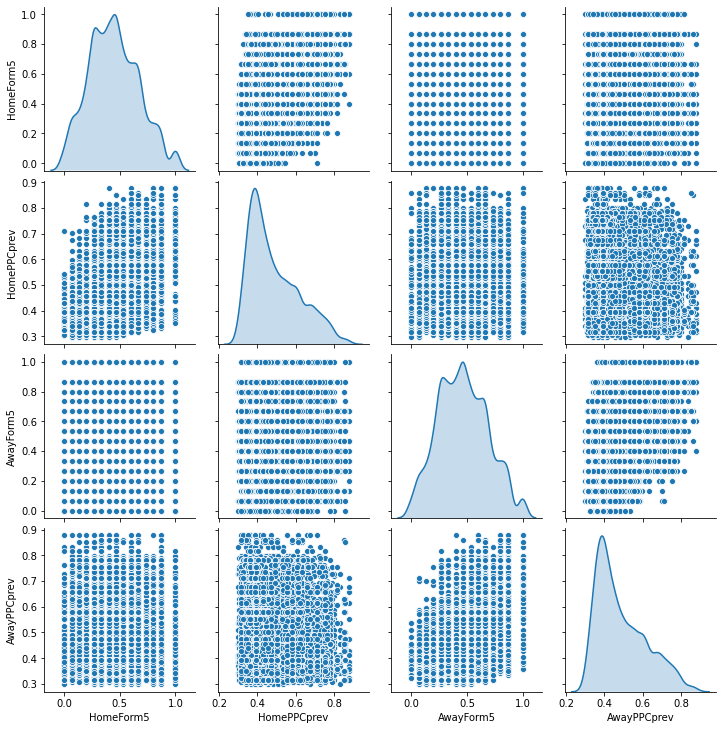

In [978]:
ax = sns.pairplot(EPL[['HomeForm5','HomePPCprev', 'AwayForm5', 'AwayPPCprev']], diag_kind='kde')

In order to 'improve' the distributions of the 'PPCprev' variables, appropriate boxcox transformations can be used to reduce the skewness in each case. I will define two new columns containing the transformed 'PPCprev' variables after performing optimal boxcox transformations - 'HomePPCprev_tf' and 'AwayPPCprev_tf'.

In [979]:
# get optimum lambda values for boxcox transformations of home and away PPC previous data
home_lambda = boxcox(EPL['HomePPCprev'].dropna())[1]
away_lambda = boxcox(EPL['AwayPPCprev'].dropna())[1]

In [980]:
# create new columns with boxcox transformed Home/AwayPPCprev data
EPL['HomePPCprev_tf'] = spboxcox(EPL['HomePPCprev'], home_lambda)
EPL['AwayPPCprev_tf'] = spboxcox(EPL['AwayPPCprev'], away_lambda)

For comparative purposes, I have plotted the distribution of the original variables along with their QQ-plots (showing how close the data are to following a normal distribution) on the top row below, and the equivalent plots for the transformed variables bottom row.

Although the transformed variables appear to move further away from a normal distribution towards both tails, the boxcox transformations appear to have improved their distributions overall.

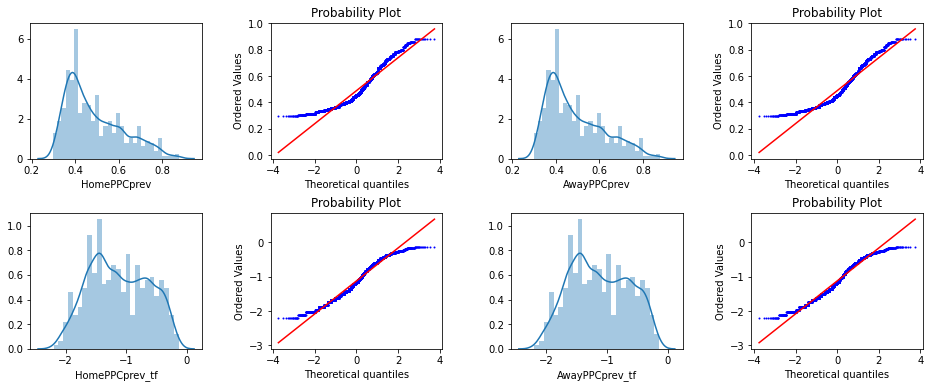

In [981]:
# set up plot size to plot 8 separate plot (2 rows of 4 plots), each of size 4x4
fig = plt.figure(figsize=(16,6))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# plot distribution and QQ-plot for original PPCprev data
ax1 = plt.subplot(241)
plot1 = sns.distplot(EPL['HomePPCprev'])
ax2 = plt.subplot(242)
plot2 = probplot(EPL['HomePPCprev'].dropna(), dist=norm, plot=plt)
ax2.get_lines()[0].set_markersize(1)
ax3 = plt.subplot(243)
plot3 = sns.distplot(EPL['AwayPPCprev'])
ax4 = plt.subplot(244)
plot4 = probplot(EPL['AwayPPCprev'].dropna(), dist=norm, plot=plt)
ax4.get_lines()[0].set_markersize(1)

# plot distribution and QQ-plot for boxcox transformed PPCprev data
ax5 = plt.subplot(245)
plot5 = sns.distplot(EPL['HomePPCprev_tf'])
ax6 = plt.subplot(246)
plot6 = probplot(EPL['HomePPCprev_tf'].dropna(), dist=norm, plot=plt)
ax6.get_lines()[0].set_markersize(1)
ax7 = plt.subplot(247)
plot7 = sns.distplot(EPL['AwayPPCprev_tf'])
ax8 = plt.subplot(248)
plot8 = probplot(EPL['AwayPPCprev_tf'].dropna(), dist=norm, plot=plt)
ax8.get_lines()[0].set_markersize(1)

I'll now recreate the pairs plot of the data but also showing the 'PPC' variables and the newly transformed 'PPCprev_tf' variables, but this time with scatter plots and regression lines shown on the lower triangle, density plots shown on the diagonal and correlation dots shown on the upper triangle of the grid of plots.

To show the correlation dots, we need to define a function for plotting dots with colour and size proportional to correlation coefficient value, which can be used to visulaise correlation between variables on a PairGrid pairs plot.

In [982]:
def corrdot(*args, **kwargs):
    corr_r=args[0].corr(args[1], 'pearson')
    corr_text=f"{corr_r:2.2f}".replace("0.", ".")
    ax=plt.gca()
    ax.set_axis_off()
    marker_size=abs(corr_r)*10000
    ax.scatter([.5],[.5],marker_size,[corr_r],alpha=0.6,cmap="coolwarm",
              vmin=-1, vmax=1, transform=ax.transAxes)
    font_size=abs(corr_r)*40+5
    ax.annotate(corr_text, [.5, .5,], xycoords="axes fraction",
               ha='center', va='center', fontsize=font_size)

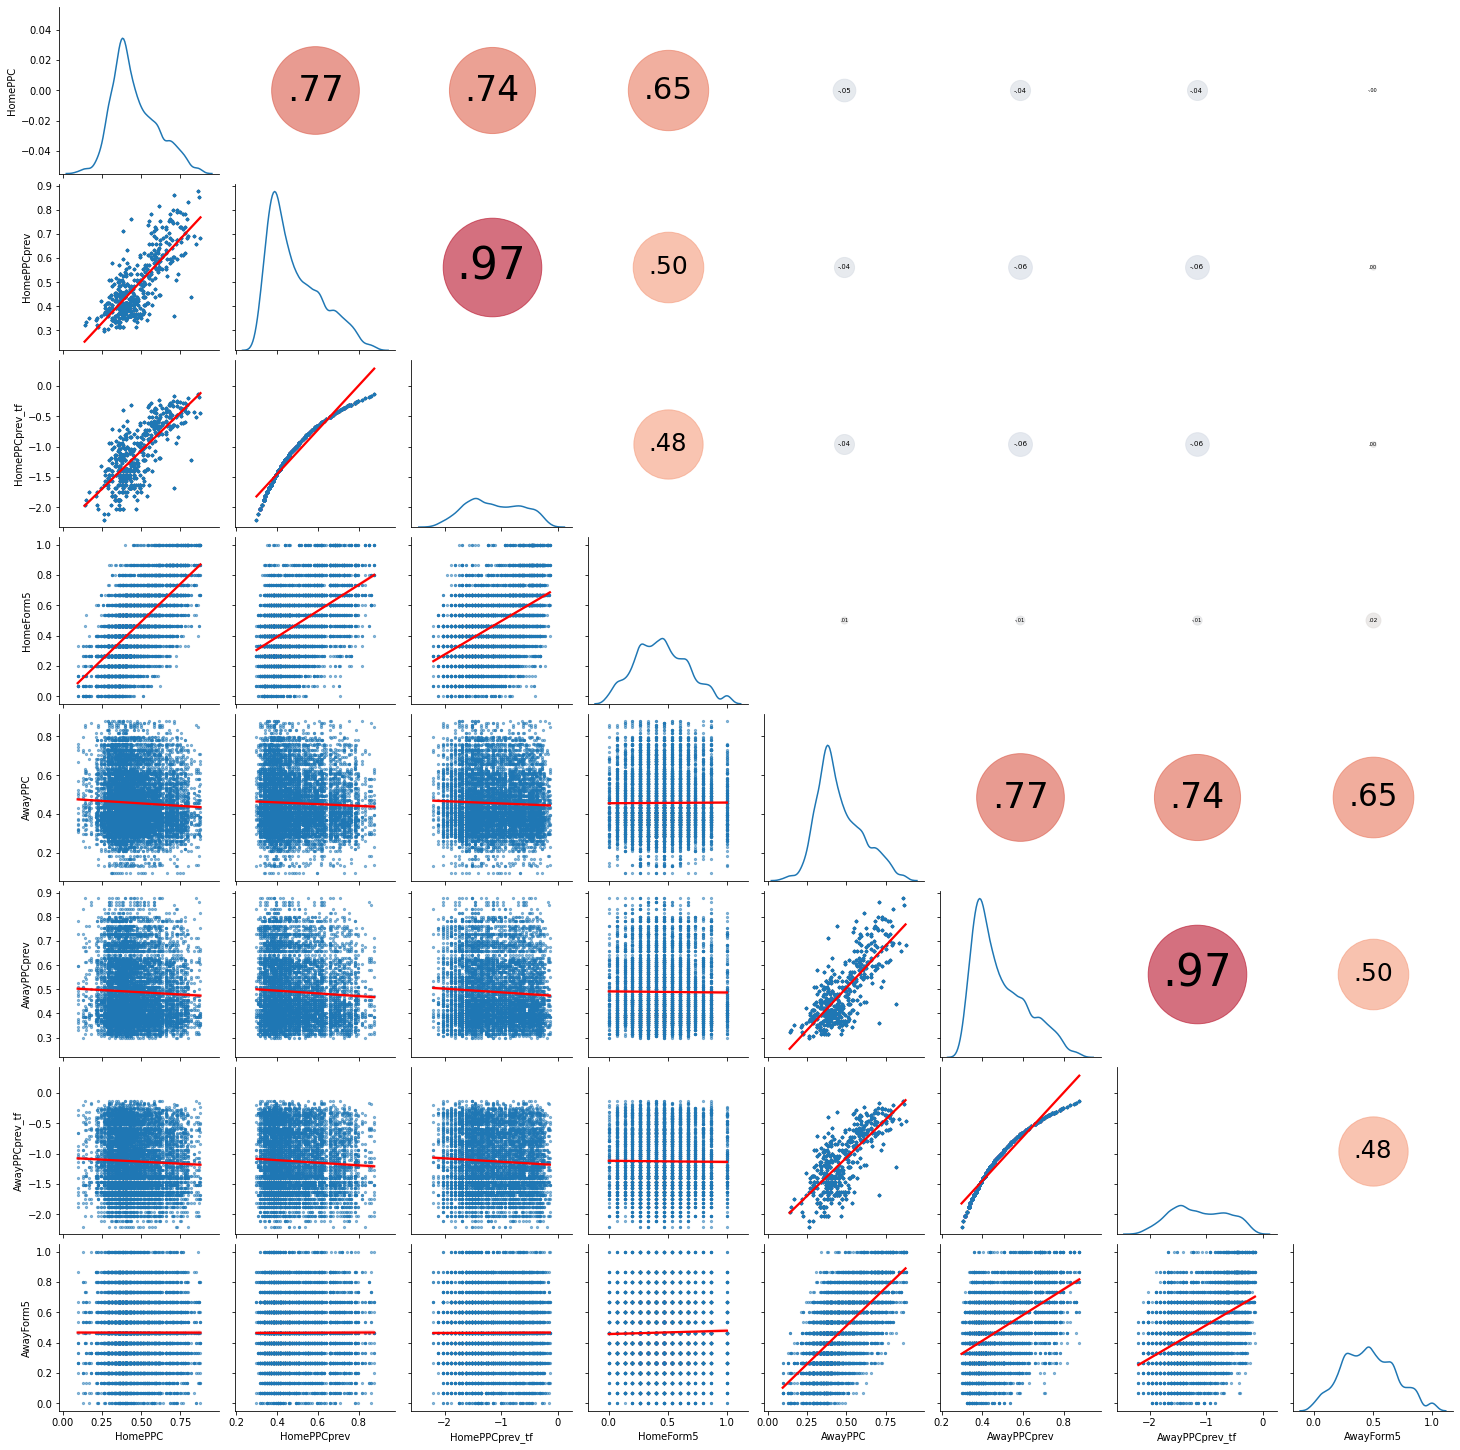

In [983]:
g=sns.PairGrid(EPL[['HomePPC','HomePPCprev','HomePPCprev_tf','HomeForm5','AwayPPC','AwayPPCprev','AwayPPCprev_tf','AwayForm5']])
g=g.map_lower(sns.regplot, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
g=g.map_diag(sns.kdeplot)
g=g.map_upper(corrdot)

We can also use a number of plots to help visualise the relationship between 'HomePPCprev', 'AwayPPCprev' and 'FTR'. Below, the scatter plot shows the 'HomePPCprev' and 'AwayPPCprev' values for all fixtures (where available) and with data point colours based off the result. While there is no clear separation visible between the classes, There appears to be a slightly higher concentration of 'H' results near the bottom right of the plot (i.e. high 'HomePPCprev' value and low 'AwayPPCprev' value), and a slightly higher concentration of 'A' results near the top left of the plot (i.e. high 'AwayPPCprev' value and low 'HomePPCprev' value) which would be expected.

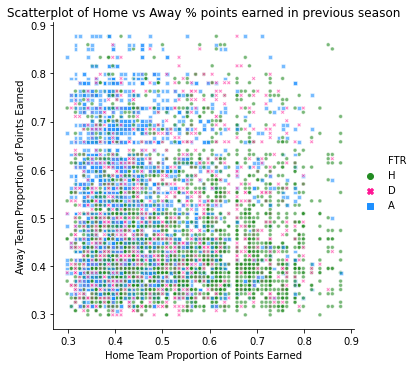

In [984]:
plot1 = sns.relplot(data=EPL, x='HomePPCprev', y='AwayPPCprev', hue='FTR', style='FTR', kind='scatter', s=15, alpha=0.6,
            palette=dict(H='forestgreen', D='deeppink', A='dodgerblue')).set(xlabel='Home Team Proportion of Points Earned',
                                             ylabel='Away Team Proportion of Points Earned', title='Scatterplot of Home vs Away % points earned in previous season')

The boxplots below show the distribution of the difference in 'HomePPCprev' and 'AwayPPCprev' values for each fixture, again separated based on the full time result. There appears to be a clear relationship between the difference in the percentage of points earned by the home and away teams in the previous season and the full time result based on this plot.

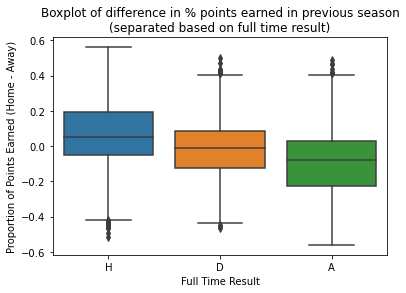

In [985]:
plot2 = sns.boxplot(EPL['FTR'], EPL['HomePPCprev']-EPL['AwayPPCprev']).set(xlabel='Full Time Result', ylabel='Proportion of Points Earned (Home - Away)',
                                                title='Boxplot of difference in % points earned in previous season\n(separated based on full time result)')

We can produce similar plots to visualise the relationship between 'HomeForm5', 'AwayForm5' and 'FTR'. 

As there are only 15 possible achievable form values, many of the points on the scatter plot would overlap making it difficult to visualise the data in such a plot. Therefore, I have created a copy of the EPL dataframe below, and added random noise (or jitter) to the form values so that it is easier to visulaise the data.

A similar trend to the 'PPCprev' scatter plot above is observed, with home wins more prominent as home form increases and away form decreases, and away wins more prominent as away form increases and home form decreases.

In [986]:
EPL_copy = EPL.copy()
# create vectors of uniform random jitter values between -0.5 and 0.5
rand_unif1 = np.random.uniform(low=-0.5, high=0.5, size=EPL_copy.shape[0])
rand_unif2 = np.random.uniform(low=-0.5, high=0.5, size=EPL_copy.shape[0])
# add random jitter to the 'Form5' columns
EPL_copy['HomeForm5'] = EPL_copy['HomeForm5'] + rand_unif1
EPL_copy['AwayForm5'] = EPL_copy['AwayForm5'] + rand_unif2

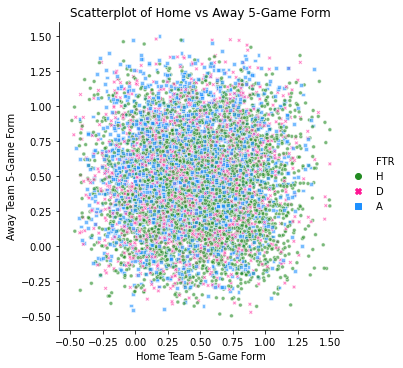

In [987]:
plot3 = sns.relplot(data=EPL_copy, x='HomeForm5', y='AwayForm5', hue='FTR', style='FTR', kind='scatter', s=15, alpha=0.6,
            palette=dict(H='forestgreen', D='deeppink', A='dodgerblue')).set(xlabel='Home Team 5-Game Form',
                                             ylabel='Away Team 5-Game Form', title='Scatterplot of Home vs Away 5-Game Form')

The boxplots below show the distribution of the difference in 'HomeForm5' and 'AwayForm5' values for each fixture, again separated based on the full time result. Again, there appears to be a relationship visible between form and full time result.

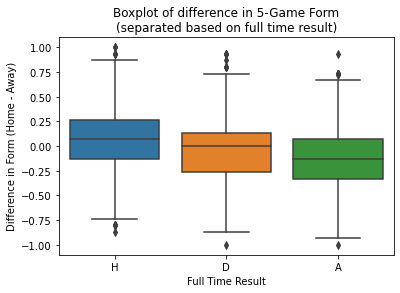

In [988]:
plot4 = sns.boxplot(EPL['FTR'], EPL['HomeForm5']-EPL['AwayForm5']).set(xlabel='Full Time Result', ylabel='Difference in Form (Home - Away)',
                                                title='Boxplot of difference in 5-Game Form\n(separated based on full time result)')

### 6. Impute unavailable values for points in previous season and form

There are several cases where it was not possible to calculate the proportion of points earned by a team in the previous year (i.e. cases where teams are newly promoted, and for all teams in the first available season) and the form value over the past 5 games (i.e. first 5 games for each team each season).

From the correlation dots on the pairs plot above (and as would be expected), we can see that there is a relatively strong correlation between the proportion of points earned by teams in the current season and they're 5 game form value, so it seems reaonable to use the home and away proportion of points earned in the current season to impute the unknown values of 5 game home form and away form respectively. As there are only a finite number of possible form values that a team can have, and they are bounded between 0 and 15, I will use ordinal logistic regression to estimate the probabilities for each unknown form value of being each of the possible 15 values, and I will randomly sample from these probabilities as an estimate of the unknown form value (rather than choosing most probable value, to preserve variance in the data).

Likewise, there is a similarly strong correlation between the proportion of points earned by teams in the current season and the proportion of points they earned in the previous season. We can use this relationship to impute values for the unknown proportion of points earned in the previous year values using simple linear regression.

In [989]:
print("Home:", EPL['HomePPC'].corr(EPL['HomeForm5']), ", Away:", EPL['AwayPPC'].corr(EPL['AwayForm5']))

Home: 0.645440698475821 , Away: 0.6505244996144792


In [990]:
print("Home:", EPL['HomePPC'].corr(EPL['HomePPCprev_tf']), ", Away:", EPL['AwayPPC'].corr(EPL['AwayPPCprev_tf']))

Home: 0.7416225709613654 , Away: 0.7416225723584337


We can also visualise this relationship using scatter plots with a lowess regression line overlaid. As shown below, the relationship in each case (even though there is a significant amount of variation in the data) is approximately linear.

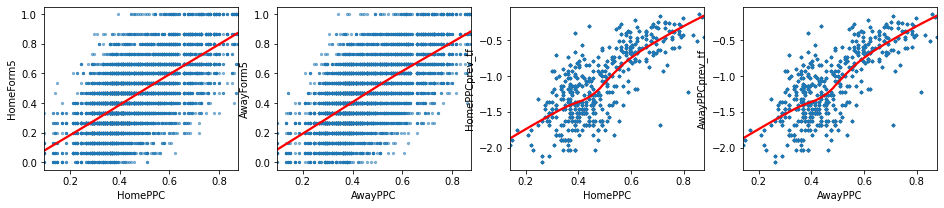

In [991]:
# set up plot size
plt.figure(figsize=(16,3))

ax1 = plt.subplot(141)
plot1 = sns.regplot(EPL['HomePPC'], EPL['HomeForm5'], lowess=True, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
ax2 = plt.subplot(142)
plot2 = sns.regplot(EPL['AwayPPC'], EPL['AwayForm5'], lowess=True, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
ax3 = plt.subplot(143)
plot3 = sns.regplot(EPL['HomePPC'], EPL['HomePPCprev_tf'], lowess=True, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
ax4 = plt.subplot(144)
plot4 = sns.regplot(EPL['AwayPPC'], EPL['AwayPPCprev_tf'], lowess=True, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})

#### 6.1 Imputing unavailable form values

We will use the proportion of points earned by teams in the current season to impute their form values in cases where the form values couldn't be calculated. First we can effectively create training and test sets for the data, where training sets include HomePPC/AwayPPC and HomeForm5/AwayForm5 values for all cases where the HomeForm5/AwayForm5 values are available, and test sets include the HomePPC/AwayPPC values for the remaining cases where HomeForm5/AwayForm5 values are not available.

After training separate models for the home and away data, the predicted probabilities of belonging to each 'class' (i.e. 0,1,..,12,13,15) for each item in the test data is calculated, and the final estimated value in each case is obtained by randomly sampling the class value based on the associated class probabilities.

In [992]:
# split home form and PPC data into train and test (test will be all NaN values in HomeForm5 column)
home_x_test = EPL.loc[EPL.loc[:,'HomeForm5'].isna(),['HomePPC']]
home_x_train = EPL.loc[EPL.loc[:,'HomeForm5'].notna(),['HomePPC']]
home_y_train = (EPL.loc[EPL.loc[:,'HomeForm5'].notna(),['HomeForm5']]).values.squeeze()

# split away form and PPC data into train and test (test will be all NaN values in AwayForm5 column)
away_x_test = EPL.loc[EPL.loc[:,'AwayForm5'].isna(),['AwayPPC']]
away_x_train = EPL.loc[EPL.loc[:,'AwayForm5'].notna(),['AwayPPC']]
away_y_train = (EPL.loc[EPL.loc[:,'AwayForm5'].notna(),['AwayForm5']]).values.squeeze()

In [993]:
# encode y_train data to only include values from 0 to n categories
home_le = LabelEncoder()
home_le.fit(np.array(home_y_train))
home_y_train2 = home_le.transform(np.array(home_y_train))

away_le = LabelEncoder()
away_le.fit(np.array(away_y_train))
away_y_train2 = home_le.transform(np.array(away_y_train))

After encoding the form values, ordinal logistic regression models can be fitted to the 'training' data above, and these models can be used to predict the probabilities associated with each possible form value for the 'test' data where the 'Form5' values couldn't be directly calcuated for a team.

In [994]:
# fit training data to ordinal logistic regression model (home form data)
ord_reg_home = mord.LogisticAT()
ord_reg_home.fit(np.array(home_x_train), np.array(home_y_train2))
# generate class probabilities for the test data from the model
home_y_predprobs = ord_reg_home.predict_proba(home_x_test)

# fit training data to ordinal logistic regression model (away form data)
ord_reg_away = mord.LogisticAT()
ord_reg_away.fit(np.array(away_x_train), np.array(away_y_train2))
# generate class probabilities for the test data from the model
away_y_predprobs = ord_reg_away.predict_proba(away_x_test)

After obtaining class probabilities above for the unknown form values, we could just take the highest probability class and use this as the imputed value in each case. However, this can reduce the variance in the variable where the values are being imputed and can result in overestimation in the correlation between variables. 

To reduce the likelihood of these issues occurring, I have decided to perform a stochastic method of imputation, sampling each of the unknown form values randomly using the predicted probabilities.

In [995]:
# create list of possible form values (integers from 0 to 15 but with 14 omitted)
form_classes = list(range(16))
form_classes.remove(14)
# loop through all values in the list and divide by 15 (to give a value in the range of 0 to 1)
for i in range(len(form_classes)): form_classes[i] = form_classes[i]/15

# create 1d arrays of zeros to store estimated form values
home_y_pred = np.zeros(home_y_predprobs.shape[0])
away_y_pred = np.zeros(away_y_predprobs.shape[0])

# set seed
np.random.seed(20203868)

# loop through all rows of the predicted probabilities array 
for i in range(home_y_predprobs.shape[0]):
    # get list of class probabilities for the current form value
    problist = home_y_predprobs[i,:]
    # sample the form value based on the probabilities, add to array of predicted values
    home_y_pred[i] = np.random.choice(form_classes, 1, p=problist)
    
# loop through all rows of the predicted probabilities array 
for i in range(away_y_predprobs.shape[0]):
    # get list of class probabilities for the current form value
    problist = away_y_predprobs[i,:]
    # sample the form value based on the probabilities, add to array of predicted values
    away_y_pred[i] = np.random.choice(form_classes, 1, p=problist)

Plotting density plots of the original and imputed values for Home and Away 'Form5' values shows that they appear to follow very similar distributions, and the scatter plots below plotting the original and imputed 'Form5' values versus their corresponding 'PPC' values appears to show similar variance in the original and imputed data as desired.

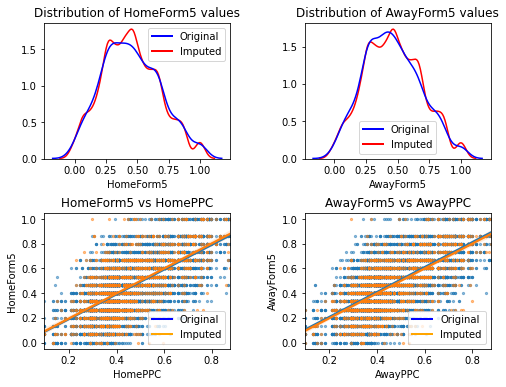

In [996]:
# set up plot size
plt.figure(figsize=(8,6))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# plot distribution of original and newly imputed HomeForm5 values
ax1 = plt.subplot(221)
plot1 = sns.kdeplot(home_y_train, legend=True, color='r').set(title='Distribution of HomeForm5 values', xlabel='HomeForm5')
plot2 = sns.kdeplot(home_y_pred, legend=True, color='b')
plot2.legend([Line2D([0], [0], color='b', lw=2), Line2D([0], [0], color='r', lw=2)], ['Original', 'Imputed'])

# plot distribution of original and newly imputed AwayForm5 values
ax2 = plt.subplot(222)
plot3 = sns.kdeplot(away_y_train, legend=True, color='r').set(title='Distribution of AwayForm5 values', xlabel='AwayForm5')
plot4 = sns.kdeplot(away_y_pred, legend=True, color='b')
plot4.legend([Line2D([0], [0], color='b', lw=2), Line2D([0], [0], color='r', lw=2)], ['Original', 'Imputed'])

# plot distribution of original and newly imputed HomeForm5 values
ax3 = plt.subplot(223)
plot5 = sns.regplot(home_x_train, home_y_train, scatter_kws={'alpha':0.5, 's':5}).set(title='HomeForm5 vs HomePPC', ylabel='HomeForm5')
plot6 = sns.regplot(home_x_test, home_y_pred, scatter_kws={'alpha':0.5, 's':5})
plot6.legend([Line2D([0], [0], color='b', lw=2), Line2D([0], [0], color='orange', lw=2)], ['Original', 'Imputed'])

ax4 = plt.subplot(224)
plot7 = sns.regplot(away_x_train, away_y_train, scatter_kws={'alpha':0.5, 's':5}).set(title='AwayForm5 vs AwayPPC', ylabel='AwayForm5')
plot8 = sns.regplot(away_x_test, away_y_pred, scatter_kws={'alpha':0.5, 's':5})
plot8.legend([Line2D([0], [0], color='b', lw=2), Line2D([0], [0], color='orange', lw=2)], ['Original', 'Imputed'])

As the imputed values appear to be reasonable, they can be added to the EPL dataframe.

We can now recreate the last 2 plots above but with the original and imputed 'Form5' values now combined in the EPL dataframe.

In [997]:
# add imputed form values to the EPL dataframe
EPL.loc[EPL.loc[:,'HomeForm5'].isna(),['HomeForm5']] = home_y_pred
EPL.loc[EPL.loc[:,'AwayForm5'].isna(),['AwayForm5']] = away_y_pred

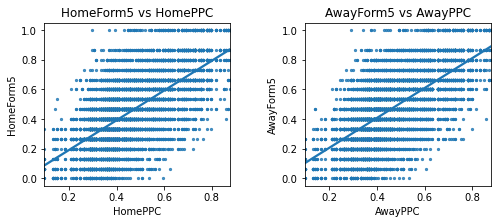

In [998]:
# set up plot size
plt.figure(figsize=(8,3))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# plot distribution of original and newly imputed HomeForm5 values
ax1 = plt.subplot(121)
plot1 = sns.regplot(EPL['HomePPC'], EPL['HomeForm5'], scatter_kws={'s':5}).set(title='HomeForm5 vs HomePPC')
# plot distribution of original and newly imputed AwayForm5 values
ax2 = plt.subplot(122)
plot2 = sns.regplot(EPL['AwayPPC'], EPL['AwayForm5'], scatter_kws={'s':5}).set(title='AwayForm5 vs AwayPPC')

#### 6.2 Imputing unavailable Home/AwayPPCprev values

We will use the proportion of points earned by teams in the current season to impute the proportion of points they earned in the previous season in cases where these values couldn't be calculated. First we can effectively create training and test sets for the data. 

Linear regression will firm the basis of the imputation method in this instance, but again for the reasons mentioned above when imputing form values a stochastic regression imputation method will be used. Here, we will first fit linear regression models on all data where 'PPCprev' values are available, and predict 'PPCprev' values for all cases where this couldn't be determined. We will then randomly sample the imputed value from a normal distribution with mean equal to the predicted 'PPCprev' value, and standard deviation equal to the standard error in the 'training' data.

Ideally, these linear regression models should satisfy the assumption of homoskedasticity, meaning that the residuals of the model should have a constant variance across the range of 'PPC' values. If there is significant differences  in the variance across the range of 'PPC' values, then adding random noise to the predicted values based on the overall standard error of the data will not be a valid method of performing stochastic imputation, as we will tend to significantly overestimate or underestimate the standard error in certain cases depedning on the predicted 'PPCprev' value.

Comparing residual plots for the 'HomePPCprev' and 'HomePPCprev_tf' variables versus 'HomePPC', it appears that the transformed 'HomePPCprev_tf' values follow closer to this assumption than the original data, so I will use the boxcox transformed data when fitting the models initially.

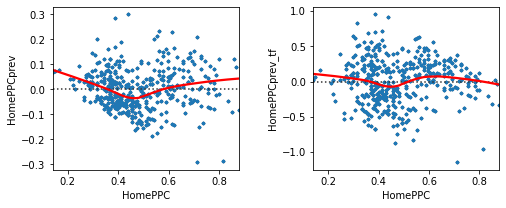

In [999]:
# set up plot size
plt.figure(figsize=(8,3))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax1 = plt.subplot(121)
plot1 = sns.residplot(EPL['HomePPC'], EPL['HomePPCprev'], lowess=True, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
ax2 = plt.subplot(122)
plot2 = sns.residplot(EPL['HomePPC'], EPL['HomePPCprev_tf'], lowess=True, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})

Another potential issue that needs to be considered is that the 'PPCprev' values we need to predict are bounded in the range of 0 to 1. Therefore, it is possible that after adding the random noise to our predicted values, they could potentially fall outside of this range. There are a number of ways to deal with this, such as clamping values between the range of 0 to 1, but this could result in an excessive number of 0 and 1 values.

Instead, I have decided to first take the predicted 'PPCprev_tf' values from the linear regression models and perform the inverse of the boxcox transformation used earlier to change them to the same form as the 'PPCprev' data. Then I will use a logit transformation on these data, and at this stage I will add the random noise value (based on a similarly scaled value of the standard error of the original data). And finally I will use a logistic transformation to reverse the logit transformation, and return imputed 'PPCprev' values which are bounded between 0 and 1. I have defined the logit and logistic transformation functions below.

In [1000]:
# logit transformation function
def logit_tf(p):
    return np.log(p / (1-p))
# logistic transformation function
def logistic_tf(x):
    return 1 / (1 + np.exp(-x))

Again, we can create 'training' data based on the data where 'PPCprev' values were available, and the 'test' data in this case will be all cases where 'PPCprev' values couldn't be determined, and linear regression models can be fitted using the training data.

In [1001]:
# split home form and PPC data into train and test (test will be all NaN values in HomePPCprev_tf column)
homep_x_test = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].isna(),['HomePPC']]
homep_x_train = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].notna(),['HomePPC']]
homep_y_train = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].notna(),['HomePPCprev_tf']]

# split away form and PPC data into train and test (test will be all NaN values in AwayPPCprev_tf column)
awayp_x_test = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].isna(),['AwayPPC']]
awayp_x_train = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].notna(),['AwayPPC']]
awayp_y_train = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].notna(),['AwayPPCprev_tf']]

In [1002]:
# fit linear regression model to home training data, predict values for the missing HomePPCprev values
regr_homep = linear_model.LinearRegression()
regr_homep.fit(homep_x_train, homep_y_train)
homep_y_pred = regr_homep.predict(homep_x_test)

# fit linear regression model to away training data, predict values for the missing AwayPPCprev values
regr_awayp = linear_model.LinearRegression()
regr_awayp.fit(awayp_x_train, awayp_y_train)
awayp_y_pred = regr_awayp.predict(awayp_x_test)

Then the standard error in the training data can be obtained by transforming the training data appropriately (perform inverse of the boxcox transformation used earlier, and then perform logit transformation) and getting the standard deviation of the transformed data. This value can then be used to add an appropriate level of stochastic noise to the predicted 'PPCprev' values.

Also, as teams should have a constant 'PPCprev' value across each season, I have added the same random noise value for each individual team in each season across all of their games, rather than them having a different value in each case. 

In [1003]:
# calculate standard error for known home PPCprev values (after logit transformation)
home_stderror = logit_tf(inv_boxcox(homep_y_train, home_lambda)).std()

# get data frame containing list of teams in each season with no PPCprev values
NoPPCprev = (EPL.loc[(EPL.loc[:,'HomePPCprev_tf'].isna()), ['Season', 'HomeTeam']]).drop_duplicates()

np.random.seed(321) # set seed

# get random normal samples to add to predicted home/away PPC prev values 
# (with home PPCprev strandard error)
PPCprev_rand = np.random.normal(size = len(NoPPCprev), loc = 0, scale = home_stderror)
NoPPCprev['rand'] = PPCprev_rand

In [1004]:
# get dataframe of all fixtures where home team has no PPCprev value
homep_NoPPCprev = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].isna(),['Season', 'HomeTeam']]
# add predicted values for home teams' PPC prev after boxcox and logit transorming the data
homep_NoPPCprev['Pred'] = logit_tf(inv_boxcox(homep_y_pred, home_lambda))
# add column to store random values
homep_NoPPCprev['Rand'] = 0.0
# reset row indices
homep_NoPPCprev.reset_index(drop=True, inplace=True)

# loop through each fixture in the data frame
for game in range(homep_NoPPCprev.shape[0]):
    # get random normal value for the current home team/current season
    hometeam_rand = NoPPCprev[(NoPPCprev['HomeTeam']==homep_NoPPCprev.iloc[game,]['HomeTeam']) &
    (NoPPCprev['Season']==homep_NoPPCprev.iloc[game,]['Season'])]['rand'].astype(float)
    # add random value to the Rand column
    homep_NoPPCprev.at[game,'Rand'] = hometeam_rand

# add random normal noise to predicted values and perform logisitc transform
homep_NoPPCprev['PredRand'] = logistic_tf(homep_NoPPCprev['Pred'] + homep_NoPPCprev['Rand'])

In [1005]:
# get dataframe of all fixtures where away team has no PPCprev value
awayp_NoPPCprev = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].isna(),['Season', 'AwayTeam']]
# add predicted values for away teams' PPC prev
awayp_NoPPCprev['Pred'] = logit_tf(inv_boxcox(awayp_y_pred, home_lambda))
# add column to store random values
awayp_NoPPCprev['Rand'] = 0.0
# reset row indices
awayp_NoPPCprev.reset_index(drop=True, inplace=True)

# loop through each fixture in the data frame
for game in range(awayp_NoPPCprev.shape[0]):
    # get random normal value for the current away team/current season
    awayteam_rand = NoPPCprev[(NoPPCprev['HomeTeam']==awayp_NoPPCprev.iloc[game,]['AwayTeam']) &
    (NoPPCprev['Season']==awayp_NoPPCprev.iloc[game,]['Season'])]['rand'].astype(float)
    # add random value to the Rand column
    awayp_NoPPCprev.at[game,'Rand'] = awayteam_rand

# add random normal noise to predicted values and perform logisitc transform
awayp_NoPPCprev['PredRand'] = logistic_tf(awayp_NoPPCprev['Pred'] + awayp_NoPPCprev['Rand'])

Plotting scatterplots of the original and new imputed 'PPCprev' values shows that the imputed values do appear to follow the trend of the original data, and appear to have a similar level of variance.

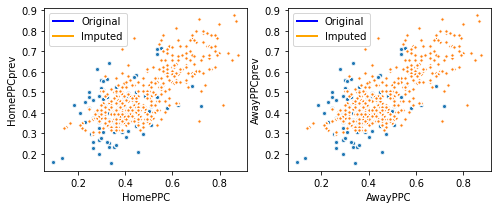

In [1006]:
# set up plot size
plt.figure(figsize=(8,3))

ax1 = plt.subplot(121)
p1=sns.scatterplot(np.array(homep_x_test).squeeze(), homep_NoPPCprev['PredRand'], s=15).set(xlabel="HomePPC", ylabel="HomePPCprev")
p2=sns.scatterplot(np.array(homep_x_train).squeeze(), np.array(inv_boxcox(homep_y_train, home_lambda)).squeeze(), s=10)
p2.legend([Line2D([0], [0], color='b', lw=2), Line2D([0], [0], color='orange', lw=2)], ['Original', 'Imputed'])

ax2 = plt.subplot(122)
p3=sns.scatterplot(np.array(awayp_x_test).squeeze(), awayp_NoPPCprev['PredRand'], s=15).set(xlabel="AwayPPC", ylabel="AwayPPCprev")
p4=sns.scatterplot(np.array(awayp_x_train).squeeze(), np.array(inv_boxcox(awayp_y_train, away_lambda)).squeeze(), s=10)
p4.legend([Line2D([0], [0], color='b', lw=2), Line2D([0], [0], color='orange', lw=2)], ['Original', 'Imputed'])

As the imputed values seem reasonable, they can be added to the EPL dataframe. The scatter plots below show the same data as the previous scatter plots, but the imputed data is now included in the EPL dataframe with the original data.

In [1007]:
# add values to the EPL data frame
EPL.loc[EPL.loc[:,'HomePPCprev_tf'].isna(),['HomePPCprev_tf']] = boxcox(homep_NoPPCprev['PredRand'].values, home_lambda)
EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].isna(),['AwayPPCprev_tf']] = boxcox(awayp_NoPPCprev['PredRand'].values, away_lambda)

# add transformed values to the EPL data frame
# (inverse of boxcox transformations performed earlier)
EPL.loc[EPL.loc[:,'HomePPCprev'].isna(),['HomePPCprev']] = homep_NoPPCprev['PredRand'].values
EPL.loc[EPL.loc[:,'AwayPPCprev'].isna(),['AwayPPCprev']] = awayp_NoPPCprev['PredRand'].values

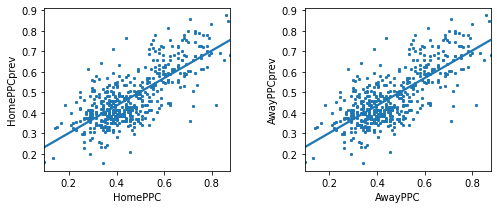

In [1008]:
# set up plot size
plt.figure(figsize=(8,3))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax1 = plt.subplot(121)
plot1 = sns.regplot(EPL['HomePPC'], EPL['HomePPCprev'], scatter_kws={'s':1})
ax2 = plt.subplot(122)
plot2 = sns.regplot(EPL['AwayPPC'], EPL['AwayPPCprev'], scatter_kws={'s':1})

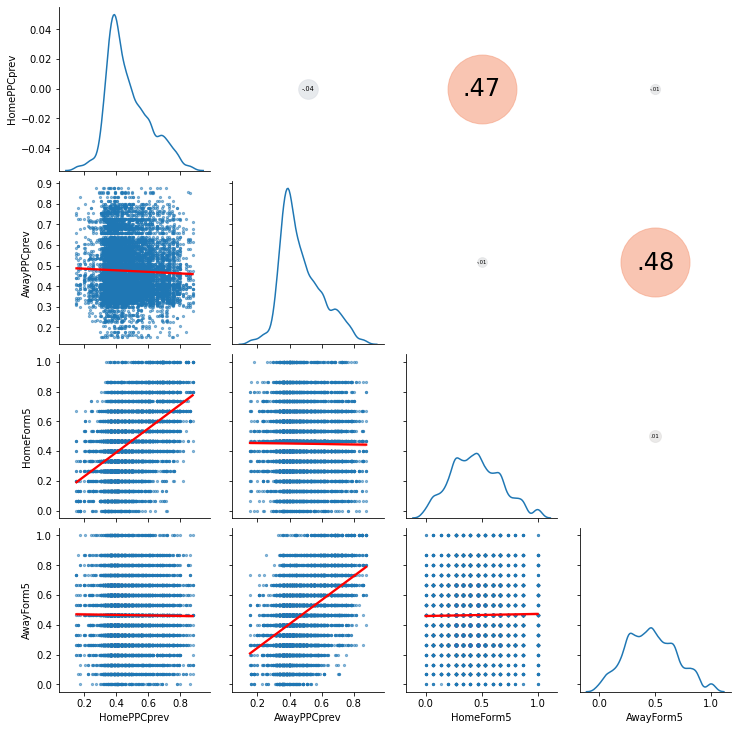

In [1009]:
g=sns.PairGrid(EPL[['HomePPCprev', 'AwayPPCprev', 'HomeForm5', 'AwayForm5', 'FTR']])
g=g.map_lower(sns.regplot, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
g=g.map_diag(sns.kdeplot)
g=g.map_upper(corrdot)

If we look at QQ-plots again for the home and away form values (with the newly imputed values included) we can see that they both appear to follow an approximate normal distribution, though the tails cut off abruptly as expected due to the possible form values being bounded between 0 and 15.

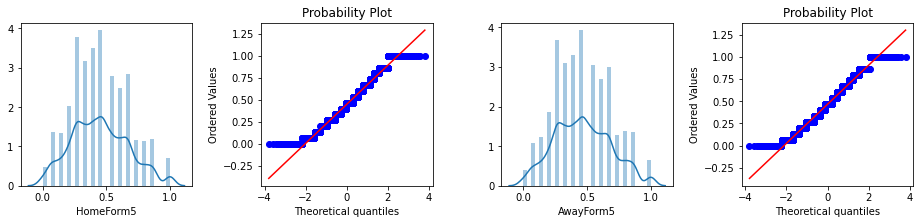

In [1010]:
# set up plot size
plt.figure(figsize=(16,3))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# plot distribution and QQ-plot for PPCprev data
ax1 = plt.subplot(141)
plot1 = sns.distplot(EPL['HomeForm5'])
ax2 = plt.subplot(142)
plot2 = probplot(EPL['HomeForm5'], dist=norm, plot=plt)
ax3 = plt.subplot(143)
plot3 = sns.distplot(EPL['AwayForm5'])
ax4 = plt.subplot(144)
plot4 = probplot(EPL['AwayForm5'], dist=norm, plot=plt)

Likewise, looking at QQ-plots for the home and away PPC prev values (with the newly imputed values included) we can see that they also appear to roughly follow a normal distribution, although the distribution of the data deviates somewhat from this towards the tails. This is again likely due to the number of achieveable points in a season - and hence proportion of points obtained in the previous season - being bounded.

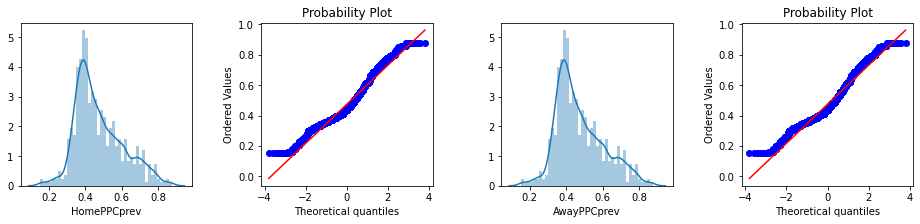

In [1011]:
# set up plot size
plt.figure(figsize=(16,3))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# plot distribution and QQ-plot for PPCprev data
ax1 = plt.subplot(141)
plot1 = sns.distplot(EPL['HomePPCprev'])
ax2 = plt.subplot(142)
plot2 = probplot(EPL['HomePPCprev'], dist=norm, plot=plt)
ax3 = plt.subplot(143)
plot3 = sns.distplot(EPL['AwayPPCprev'])
ax4 = plt.subplot(144)
plot4 = probplot(EPL['AwayPPCprev'], dist=norm, plot=plt)

In [1012]:
EPL

,Season,HomeTeam,AwayTeam,FTR,HomePPC,AwayPPC,HomePPCprev,AwayPPCprev,HomeForm5,AwayForm5,HomePPCprev_tf,AwayPPCprev_tf
0,0,Aston Villa,Man United,H,0.552632,0.719298,0.531811,0.432535,0.866667,0.800000,-0.852385,-1.255324
1,0,Blackburn,QPR,H,0.535088,0.289474,0.709829,0.267396,0.866667,0.266667,-0.401976,-2.544638
2,0,Chelsea,Everton,D,0.438596,0.535088,0.444208,0.688374,0.866667,0.400000,-1.199058,-0.444447
3,0,Liverpool,Sheffield Weds,H,0.622807,0.350877,0.438838,0.338208,0.400000,0.466667,-1.224589,-1.844715
4,0,Man City,Tottenham,D,0.333333,0.535088,0.252585,0.478921,0.533333,0.133333,-2.738081,-1.047228
...,...,...,...,...,...,...,...,...,...,...,...,...
9495,24,Leicester,Man United,A,0.543860,0.578947,0.456140,0.578947,0.466667,0.733333,-1.144383,-0.707460
9496,24,Man City,Norwich,H,0.710526,0.184211,0.859649,0.439562,0.800000,0.000000,-0.162093,-1.221110
9497,24,Newcastle,Liverpool,A,0.385965,0.868421,0.394737,0.850877,0.133333,0.666667,-1.459220,-0.173913
9498,24,Southampton,Sheffield United,H,0.456140,0.473684,0.342105,0.296654,0.600000,0.466667,-1.814251,-2.216828


### 11. Evaluating Machine Learning Models for Predicting 

Before fitting models in order to generate predict full time result probabilities for new fixtures, we can again look at some boxplots to visualise whether an relationship exists between the 'HomePPCprev', 'AwayPPCprev', 'HomeForm5' and 'AwayForm5' variables (which I plan to use as predictor variables in the model) and the 'FTR' variable (which will be the target variable in the model). 

In each case, there appears to be evidence of such a relationship based off these plots.

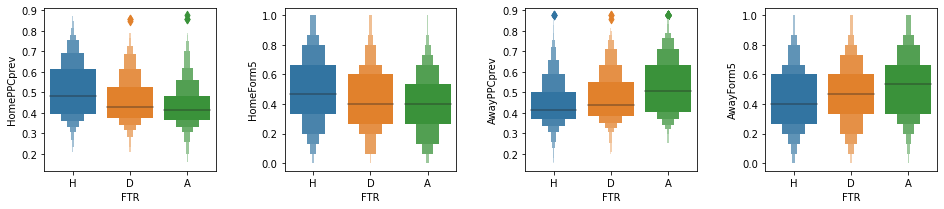

In [1013]:
# set up plot size
plt.figure(figsize=(16,3))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax1 = plt.subplot(141)
plot1=sns.boxenplot(EPL['FTR'], EPL['HomePPCprev'])
ax2 = plt.subplot(142)
plot2=sns.boxenplot(EPL['FTR'], EPL['HomeForm5'])
ax3 = plt.subplot(143)
plot3=sns.boxenplot(EPL['FTR'], EPL['AwayPPCprev'])
ax4 = plt.subplot(144)
plot4=sns.boxenplot(EPL['FTR'], EPL['AwayForm5'])

Next, I will define a number of functions which can be reused when fitting and evaluating each of the models being tested. The first function takes a list of data in the form of folds to be used in k-fold cross-validation, as well as the number of folds and the current fold iteration. Based on these arguments, it returns the sets of training and validation data for the current iteration of the cross-validation.

In [1025]:
def get_train_val_folds(folds, numfolds, k):
    # use current fold as the current validation set
    val_fold = folds[k]
    # separate x and y validation data based on columns
    valx = val_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    valy = val_fold['FTR'].values

    # combine remaining folds to use as current training set
    train_ind_list = list(range(numfolds))
    train_ind_list.remove(k)
    train_fold = pd.concat([folds[i] for i in train_ind_list])
    # separate x and y training data based on columns
    trainx = train_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    trainy = train_fold['FTR'].values
    
    # return training and validation sets for current iteration
    return trainx, trainy, valx, valy

The function below takes a given model, fits it using given training data, and returns predicted class probabilities for given validation data.

In [1015]:
# function to fit data to given model and predict values for validation data
def model_fit_predict(model, trainx, trainy, valx):
    # fit training data to model
    model.fit(trainx, trainy)
    # get class predictions and class probabilities
    preds_mod = model.predict(valx)
    probs_mod = model.predict_proba(valx)
    # return class predictions and class probabilities
    return model, preds_mod, probs_mod

The next function below takes a target variable whose entries may be of string type. It then performs label encoding to convert the string values to numeric values, and finally it performs one hot encoding on the numeric vector and returns an array corresponding to the one hot encoded target variable. This functionality is required when calculating the Ranked Probability Score for each model, which will be described later.

In [1016]:
# function to perform one hot encoding on class vector in string format 
def myOneHotEncoder(targets):
    le = LabelEncoder() # define label encoder object
    targets_num = le.fit_transform(targets) # generate numeric vector corresponding to classes
    enc = OneHotEncoder() # define one hot encoder object
    return enc.fit_transform(targets_num.reshape(-1, 1)).toarray() # return one hot encoded array

The next function generates an array corresponding to class probabilities for the specified target variable, but each row has identical class probabilities corresponding to the proportion of each of the classes in the given training data. These probabilities will be used for generating a reference or baseline model which will in turn be used to evaluate the performance of each model via the Ranked Probability Skill Score.

In [1017]:
# function to calculate reference probabilities based off class proportions in training data
def get_ref_probs(targets, classes, trainy):
    N = len(targets) # number of observations
    probs0 = np.array([0.0]*len(classes)) # create vector of 0s, length equal to number of classes
    
    # loop through each class
    for i in range(len(classes)):
        probs0[i] = len(trainy[trainy==classes[i]])/len(trainy) # calculate proportion of current class in the training data
    
    probs = np.array([probs0,]*N) # create array of length num.observations with reference probabilities repeated
    
    return probs

The following 2 functions are then used to calculate the Ranked Probability Score (RPS) and Ranked Probability Skill Score (RPSS) for each of our models, which is the metric I have chosen to evaluate and compare the performance of each model. Note that the RPS/RPSS take into account the ordinal nature of our target variable and the target variable and corresponding predicted class probabilities must be ordered appropriately for the metric to be valid (i.e. order of classes must be either A-D-H or H-D-A).

The RPSS compares the model to the reference/baseline model as descrived above, with a positive value indicating an improvement on the reference model and a negative value indicating a worse performance than the reference model.

In [1018]:
# function to calculate ranked probability score
# both targets and probs must be ordered appropriately (e.g. A,D,H or H,D,A)
def rps(targets, probs):
    targets = myOneHotEncoder(targets) # use one hot encoding to convert target vector to binary array
    RPS = 0
    N = targets.shape[0] # number of observations
    r = targets.shape[1] # number of classes
    
    for t in range(N): # loop through all rows (observations)
        for i in range(r-1): # loop through classes (minus the final class)
            inner_sum = 0 # initialise the inner sum value as 0
            
            for j in range(i+1): # loop from 0 to i+1
                inner_sum += (probs[t, j] - targets[t, j]) # add difference between current prob. and target value to inner sum
                
            RPS += inner_sum**2 # square inner sum value after completion of inner loop
            
    RPS = RPS/((r-1)*N) # divide RPS by num.classes-1, and also by num.observations
    
    return RPS

In [1019]:
# calculate ranked probability skill score
def rpss(rps, rps_ref):
    return 1 - (rps/rps_ref)

The following function combines the functions above to fit training data to a given model, generate predicted class probabilities for given validation data, and evaluate the performance of the model via the RPSS metric.

In [1020]:
# function to fit model and evaluate on validation data using RPSS
# (Ranked Probability Skill Score)
def fit_eval_rpss(model, trainx, trainy, valx, valy):
    # predict classes and get class probabilities for validation data
    model, preds_mod, probs_mod = model_fit_predict(model, trainx, trainy, valx)
    
    # get ranked probability score for the validation data using predicted classes
    RPS = rps(valy, probs_mod)
    
    # get probabilities for reference case where training data proportions are used
    ref_probs = get_ref_probs(valy, np.unique(trainy), trainy)
    # get ranked probability skill score for the validation data using predicted classes
    RPS_ref = rps(valy, ref_probs)
    RPSS = rpss(RPS, RPS_ref)
     
    return RPSS

Finally, I have defined a plotting function which takes an array of RPSS values calculated during a cross-validation procedure for multiple models and plots both boxplots showing the distribution of RPSS values obatined for each model, and also a line plot showing the mean RPSS value obatined for each model.

In [1021]:
def plot_rpss(rpss_data):    
    # set up plot size
    plt.figure(figsize=(9,4))
    # increase spacing between figures
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # plot boxplots
    ax1 = plt.subplot(121)
    plot1 = sns.boxplot(data=rpss_data)
    ax1.plot(np.mean(rpss_data, axis=0),'r-o',linewidth=2)
    # plot mean values
    ax2 = plt.subplot(122)
    plot2 = plt.plot(np.mean(rpss_data, axis=0))
    ax2.set_xticks(range(rpss_data.shape[1]))
    plt.grid()

## Random Forest Models Evaluation

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % Complete ( 3 reps, 5 folds )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Complete!
Optimum Random Forest Parameters: [1500, 6]


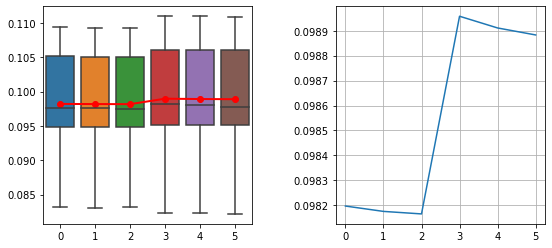

In [1059]:
%%time

# set number of reps and folds
num_folds = 5
num_reps = 3

# define list of parameters to trial, and calculate number of models
rf_params = np.array([[1500, 5], [2000, 5], [2500, 5],
                      [1500, 6], [2000, 6], [2500, 6]])
num_models = len(rf_params)

# set initial values for progress bar and print top line above progress bar
progress=0
progress_last=0
progress_diff=0
print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % Complete (",
      num_reps, "reps,", num_folds, "folds )")

# create array of zeros to store rpss values for each model over each rep/fold
rf_rpss = np.zeros(shape=[num_folds*num_reps, num_models])

for rep in range(num_reps): # loop through number of reps specified
    
    # generate list of folds from the full set of training/validation data (randomly shuffled)
    folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)
    
    for k in range(num_folds): # loop through number of folds specified
        
        # get training and validation sets for the current fold iteration       
        train_x, train_y, val_x, val_y = get_train_val_folds(folds, num_folds, k)

        # fit/evaluate Random Forest models
        for j in range(num_models):
            rf_mod = rf(n_estimators=rf_params[j,0], max_depth=rf_params[j,1], random_state=0)
            rf_rpss[k + rep*num_folds,j] = fit_eval_rpss(rf_mod, train_x, train_y, val_x, val_y)

        # update values for progress bar
        progress = ((rep)*num_folds + (k+1))/((num_reps)*(num_folds))*100
        progress_diff = np.floor(progress - progress_last).astype(int)
        progress_last = progress_last + progress_diff
        # print bars corresponding to current progress
        for i in range(progress_diff):
            print("|", end="")

print("\n\nComplete!")

print("Optimum Random Forest Parameters:",list(rf_params[np.argmax(np.mean(rf_rpss, axis=0))]))

# plot RPSS results       
plot_rpss(rf_rpss)

## Gradient Boosting Models Evaluation

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % Complete ( 3 reps, 5 folds )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Complete!
Optimum Gradient Boosting Parameters: [180, 1]


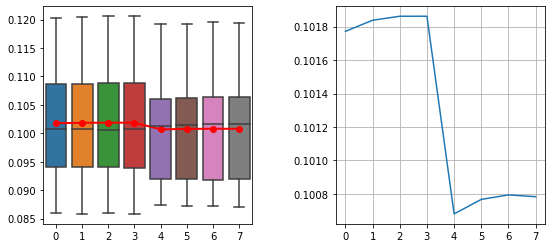

In [1052]:
%%time

# set number of reps and folds
num_folds = 5
num_reps = 3

# define list of parameters to trial, and calculate number of models
boost_params = np.array([[150, 1], [160, 1], [170, 1], [180, 1],
                         [71, 2], [73, 2], [75, 2], [77, 2]])
num_models = len(boost_params)

# set initial values for progress bar and print top line above progress bar
progress=0
progress_last=0
progress_diff=0
print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % Complete (",
      num_reps, "reps,", num_folds, "folds )")

# create array of zeros to store rpss values for each model over each rep/fold
boost_rpss = np.zeros(shape=[num_folds*num_reps, num_models])

for rep in range(num_reps): # loop through number of reps specified
    
    # generate list of folds from the full set of training/validation data (randomly shuffled)
    folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)
    
    for k in range(num_folds):  # loop through number of folds specified
        
        # get training and validation sets for the current fold iteration       
        train_x, train_y, val_x, val_y = get_train_val_folds(folds, num_folds, k)

        # fit/evaluate Gradient Boosting models
        for j in range(num_models):
            boost_mod = boost(n_estimators=boost_params[j,0], max_depth=boost_params[j,1], random_state=0)
            boost_rpss[k + rep*num_folds, j] = fit_eval_rpss(boost_mod, train_x, train_y, val_x, val_y)

        # update values for progress bar
        progress = ((rep)*num_folds + (k+1))/((num_reps)*(num_folds))*100
        progress_diff = np.floor(progress - progress_last).astype(int)
        progress_last = progress_last + progress_diff
        # print bars corresponding to current progress
        for i in range(progress_diff):
            print("|", end="")

print("\n\nComplete!")

print("Optimum Gradient Boosting Parameters:", list(boost_params[np.argmax(np.mean(boost_rpss, axis=0))]))

# plot RPSS results       
plot_rpss(boost_rpss)

## SVM Models Evaluation

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % Complete ( 3 reps, 5 folds )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Complete!
Optimum Support Vector Machines Parameters: [0.016, 1.0]


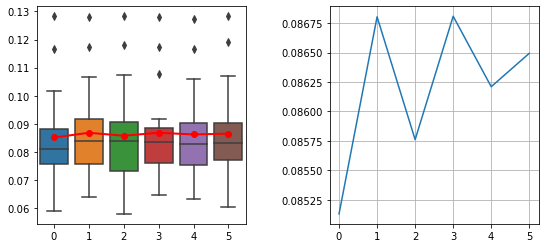

In [1060]:
%%time

# set number of reps and folds
num_folds = 5
num_reps = 3

# define list of parameters to trial, and calculate number of models
svm_params = np.array([[0.013, 1], [0.014, 1], [0.015, 1],
                       [0.016, 1], [0.017, 1], [0.018, 1]])
num_models = len(svm_params)

# set initial values for progress bar and print top line above progress bar
progress=0
progress_last=0
progress_diff=0
print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % Complete (",
      num_reps, "reps,", num_folds, "folds )")

# create array of zeros to store rpss values for each model over each rep/fold
svm_rpss = np.zeros(shape=[num_folds*num_reps, num_models])

for rep in range(num_reps): # loop through number of reps specified
    
    # generate list of folds from the full set of training/validation data (randomly shuffled)
    folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

    for k in range(num_folds):  # loop through number of folds specified
        
        # get training and validation sets for the current fold iteration       
        train_x, train_y, val_x, val_y = get_train_val_folds(folds, num_folds, k)

        # fit/evaluate Support Vector Machines models (rbf kernel)
        for j in range(num_models):
            svm_mod = svm.SVC(kernel='rbf', random_state=1, gamma=svm_params[j,0], C=svm_params[j,0], probability=True)
            svm_rpss[k + rep*num_folds,j] = fit_eval_rpss(svm_mod, train_x, train_y, val_x, val_y)

        # update values for progress bar
        progress = ((rep)*num_folds + (k+1))/((num_reps)*(num_folds))*100
        progress_diff = np.floor(progress - progress_last).astype(int)
        progress_last = progress_last + progress_diff
        # print bars corresponding to current progress
        for i in range(progress_diff):
            print("|", end="")

print("\n\nComplete!")

print("Optimum Support Vector Machines Parameters:", list(svm_params[np.argmax(np.mean(svm_rpss, axis=0))]))  

# plot RPSS results 
plot_rpss(svm_rpss)

## KNN Models Evaluation

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % Complete ( 3 reps, 5 folds )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Complete!
Optimum KNN Parameters: 230
CPU times: user 43.9 s, sys: 598 ms, total: 44.5 s
Wall time: 44.5 s


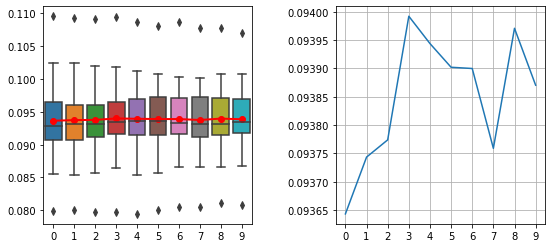

In [1061]:
%%time

# set number of reps and folds
num_folds = 5
num_reps = 3

# define list of parameters to trial, and calculate number of models
knn_params = np.array(list(range(200,300,10)))
num_models = len(knn_params)

# set initial values for progress bar and print top line above progress bar
progress=0
progress_last=0
progress_diff=0
print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % Complete (",
      num_reps, "reps,", num_folds, "folds )")

# create array of zeros to store rpss values for each model over each rep/fold
knn_rpss = np.zeros(shape=[num_folds*num_reps, num_models])

for rep in range(num_reps): # loop through number of reps specified
    
    # generate list of folds from the full set of training/validation data (randomly shuffled)
    folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

    for k in range(num_folds):  # loop through number of folds specified
        
        # get training and validation sets for the current fold iteration       
        train_x, train_y, val_x, val_y = get_train_val_folds(folds, num_folds, k)

        # fit/evaluate KNN models
        for j in range(num_models):
            knn_mod = knn(n_neighbors=knn_params[j])
            knn_rpss[k + rep*num_folds,j] = fit_eval_rpss(knn_mod, train_x, train_y, val_x, val_y)

        # update values for progress bar
        progress = ((rep)*num_folds + (k+1))/((num_reps)*(num_folds))*100
        progress_diff = np.floor(progress - progress_last).astype(int)
        progress_last = progress_last + progress_diff
        # print bars corresponding to current progress
        for i in range(progress_diff):
            print("|", end="")

print("\n\nComplete!")

print("Optimum KNN Parameters:", knn_params[np.argmax(np.mean(knn_rpss, axis=0))])  

# plot RPSS results 
plot_rpss(knn_rpss)

## All Models Evaluation

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % Complete ( 5 reps, 10 folds )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Complete!
Optimum Model: 3
CPU times: user 14min 27s, sys: 2.73 s, total: 14min 30s
Wall time: 13min 21s


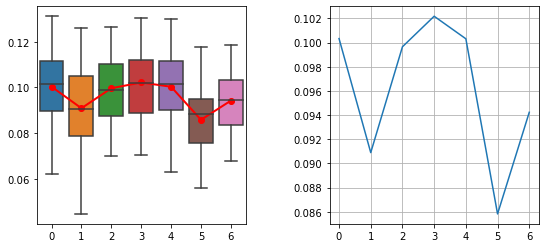

In [1062]:
%%time

# set number of reps, folds and models
num_reps = 5
num_folds = 10
num_models = 7

# set initial values for progress bar and print top line above progress bar
progress=0
progress_last=0
progress_diff=0
print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % Complete (",
      num_reps, "reps,", num_folds, "folds )")

# create array of zeros to store rpss values
models_rpss = np.zeros(shape=[num_folds*num_reps, num_models])

for rep in range(num_reps): # loop through number of reps specified
    
    # generate list of folds from the full set of training/validation data (randomly shuffled)
    folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)
    
    for k in range(num_folds): # loop through number of folds specified
        
        # get training and validation sets for the current fold iteration       
        train_x, train_y, val_x, val_y = get_train_val_folds(folds, num_folds, k)

        # fit/evaluate LDA model
        lda_mod = lda()
        models_rpss[k + rep*num_folds,0] = fit_eval_rpss(lda_mod, train_x, train_y, val_x, val_y)

        # fit/evaluate QDA model
        qda_mod = qda()
        models_rpss[k + rep*num_folds,1] = fit_eval_rpss(qda_mod, train_x, train_y, val_x, val_y)

        # fit/evaluate random forest model
        rf_mod = rf(n_estimators=1500, max_depth=6, random_state=0)
        models_rpss[k + rep*num_folds,2] = fit_eval_rpss(rf_mod, train_x, train_y, val_x, val_y)

        # fit/evaluate boosting model
        boost_mod = boost(n_estimators=180, max_depth=1, random_state=0)
        models_rpss[k + rep*num_folds,3] = fit_eval_rpss(boost_mod, train_x, train_y, val_x, val_y)

        # fit/evaluate logistic regression model
        lr_mod = logreg(random_state=0, max_iter=200)
        models_rpss[k + rep*num_folds,4] = fit_eval_rpss(lr_mod, train_x, train_y, val_x, val_y)
        
        # fit/evaluate SVM model with rbf kernel
        svm_mod = svm.SVC(kernel='rbf', random_state=1, gamma=0.016, C=1, probability=True)
        models_rpss[k + rep*num_folds,5] = fit_eval_rpss(svm_mod, train_x, train_y, val_x, val_y)
        
        # fit/evaluate KNN model
        svm_mod = knn(n_neighbors=230)
        models_rpss[k + rep*num_folds,6] = fit_eval_rpss(knn_mod, train_x, train_y, val_x, val_y)

        # update values for progress bar
        progress = ((rep)*num_folds + (k+1))/((num_reps)*(num_folds))*100
        progress_diff = np.floor(progress - progress_last).astype(int)
        progress_last = progress_last + progress_diff
        # print bars corresponding to current progress
        for i in range(progress_diff):
            print("|", end="")
        
print("\n\nComplete!")

model_list = ["LDA", "QDA", "Random Forest", "Boosting", "Logisitc Regression", "SVM", "KNN"]
print("Optimum Model:", model_list[np.argmax(np.mean(models_rpss, axis=0))])

# plot RPSS results
plot_rpss(models_rpss)

## Fitting the Best Model

In [845]:
# define full set of training data for fitting the final/best model 
xtrain = EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
ytrain = EPL['FTR'].values

In [582]:
# fit optimum model to the full set of data
mymodel = boost(n_estimators=160, max_depth=1, random_state=0)
#mymodel = lda()
mymodel.fit(xtrain, ytrain)

GradientBoostingClassifier(max_depth=1, n_estimators=160, random_state=0)

In [583]:
preds_example = list(mymodel.predict_proba(np.array([0.5, 0.7, 7, 7]).reshape(1, -1)).flatten())
preds_example # output order in the form: [Away Win probability, Draw probability, Home Win Probability]

[0.4289800637281336, 0.24673575027017625, 0.3242841860016903]

Recreate ordinal regression models for home and away form using all of our data during training. These will be used when estimating form values for each team that hasn't played 5 previous fixtures (and it isn't possible to calculate our form metric value as a result).

In [504]:
EPL['HomePPCprev'].corr(EPL['HomeForm5'])

0.4580358442784921

In [505]:
EPL['AwayPPCprev'].corr(EPL['AwayForm5'])

0.4601833880896458

Create training data with Form values for the y data and PPCprev values for the x data.

In [506]:
home_x_train = EPL[['HomePPCprev']]
home_y_train = EPL['HomeForm5'].values
away_x_train = EPL[['AwayPPCprev']]
away_y_train = EPL['AwayForm5'].values

In [507]:
# encode y_train data to only include values from 0 to n categories
home_le = LabelEncoder()
home_le.fit(np.array(home_y_train))
home_y_train2 = home_le.transform(np.array(home_y_train))

away_le = LabelEncoder()
away_le.fit(np.array(away_y_train))
away_y_train2 = home_le.transform(np.array(away_y_train))

In [508]:
# fit training data to ordinal logistic regression model (home form data)
ord_reg_home = mord.LogisticAT()
ord_reg_home.fit(np.array(home_x_train), np.array(home_y_train2))

# fit training data to ordinal logistic regression model (away form data)
ord_reg_away = mord.LogisticAT()
ord_reg_away.fit(np.array(away_x_train), np.array(away_y_train2))

LogisticAT()

Function to generate random set of fixtures given a list of teams

In [509]:
# function that generates list of fixtures given 
def generate_fixtures(teams, dropbyes=False):
    # randomly shuffle the list of teams
    shuffle(teams)
    
    # create empty dataframes to save fixtures
    myfixtures = pd.DataFrame(columns=['Gameweek', 'HomeTeam', 'AwayTeam'])
    myreturnfixtures = pd.DataFrame(columns=['Gameweek', 'HomeTeam', 'AwayTeam'])

    # get length of teams list
    n = len(teams)
    # if number of teams is odd, append 'Bye' to the list
    if n%2 != 0:
        teams.append('Bye')
        n+=1

    # loop through the first (n-1) game weeks (return fixtures not included)
    for gameweek in range(1, n):
        # loop through all fixtures in this game week
        for i in range(n//2):
            
            # reverse home and away teams every second week
            # (ensures that teams don't play at home (or away) more than 2 weeks in a row)
            if gameweek%2 == 0:
                myfixtures.loc[len(myfixtures)] = [gameweek, teams[i], teams[n - 1 - i]]
            else:
                myfixtures.loc[len(myfixtures)] = [gameweek, teams[n - 1 - i], teams[i]]

        # remove last team in teams list and insert at second position in the list
        teams.insert(1, teams.pop())
    
    # copy fixtures to the return fixtures dataframe, but with gameweek incremented and home/away teams reversed
    myreturnfixtures['Gameweek'] = myfixtures['Gameweek']+ (n-1)
    myreturnfixtures['HomeTeam'] = myfixtures['AwayTeam']
    myreturnfixtures['AwayTeam'] = myfixtures['HomeTeam']

    if dropbyes==True:
        myfixtures = myfixtures[(myfixtures['HomeTeam']!='Bye') & (myfixtures['AwayTeam']!='Bye')]
        myreturnfixtures = myreturnfixtures[(myreturnfixtures['HomeTeam']!='Bye') & (myreturnfixtures['AwayTeam']!='Bye')]
    
    # return dataframe with original fixtures and return fixtures combined
    return pd.concat([myfixtures, myreturnfixtures]).reset_index(drop=True)

In order to add variation into the system which will aid to account for major changes that happen to teams between seasons (e.g. team sign a player that improves the team significantly, or a key player is injured and the team aren't as strong as in the previous year), the HomePPCprev and AwayPPCprev can also be randomly sampled. A Beta distribution is suitable in this case as it is bounded between 0 and 1 as is required.

In order to sample a PPCprev value for an individual team, we can randomly sample the value from a Beta distribution with a specified variance and with its mode (or median) equal to the actual PPCprev value obtained by the team. The mode is preferred to the mean as the beta distribution tends to be skewed significantly when its mean is close to 0 or close to 1. In such cases the the median or mode can be a better measure of the centre of the distribution.

Using the mode instead of the median will also reduce the likelihood of teams that achieved an unusually high points total from getting an even larger PPCprev value after sampling from the beta distribution (and likewise for teams that achieved an unusually low number of points).

To calculate the $\alpha$ and $\beta$ parameter values for a Beta distribution with a specified mode and variance, we can use the following equations:

$Mode[X] = \frac{\alpha - 1}{\alpha + \beta - 2}$

$Var[X] = \frac{\alpha \beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}$

Note that this definition of the mode is valid obly when $\alpha$ and $\beta$ in our Beta function are both be greater than 1, which will be the case here.

We can solve for $\alpha$ and $\beta$ in terms of Mode[X] and Var[X], where:

$\beta = (\frac{1 - Mode[X]}{Mode[X]}) \alpha + (\frac{2 Mode[X] - 1}{Mode[X]}) = x \alpha + y$ ........ (i.e. $x = \frac{1 - Mode[X]}{Mode[X]}$ and $y = \frac{2 Mode[X] - 1}{Mode[X]}$)

and where $\alpha$ is obtained by getting the roots of the following cubic equation, and finding the root that is greater than 1 (as this is a constraint of our Beta distribution in this case):

$\alpha ^3 (x^3 + 3x^2 + 3x + 1) + 
\alpha ^2 (x^2 + 2x + 3y + 3x^2y + 6xy + 1 - \frac{x}{Var[X]}) + 
\alpha (3y^2 + 2y + 3xy^2 + 2xy - \frac{y}{Var[X]}) + 
(y^3 + y^2) = 0$  



In [516]:
# function calculates coefficients for claculating alpha for Beta distribution with specified Mode and Var
def get_beta_coefs(Mode, Var):
    # define x and y to simplify equation
    x = (1 - Mode)/Mode
    y = (2*Mode - 1)/Mode
    # calculate coefficients of cubic equation to solve for alpha value
    a =  (x**3) + 3*(x**2) + 3*x + 1
    b =  (x**2) + 2*x + 3*y + 3*(x**2)*y + 6*x*y + 1 - x/Var
    c =  3*(y**2) + 2*y + 3*x*(y**2) + 2*x*y - y/Var
    d =  (y**3) + (y**2)
    
    # get roots of the cubic equation
    roots = np.roots([a,b,c,d])
    
    # check if a root exists that is >1
    if len(roots[roots>1]) > 0:
        # set alpha to value of the root that is >1
        alpha = roots[roots>1].item()
        # set beta based on alpha
        beta = x * alpha + y
    else:
        # if no root >1, print message to reduce variance
        print("No roots greater than 1 (reduce variance value)")
        alpha = np.nan
        beta = np.nan
        
    return alpha, beta

In [525]:
aaa,bbb = get_beta_coefs(0.9,0.005)
aaa,bbb

(19.403240015170134, 3.0448044461300143)

In [526]:
dist = np.random.beta(aaa,bbb, size=10000)

[(0.0, 1.0)]

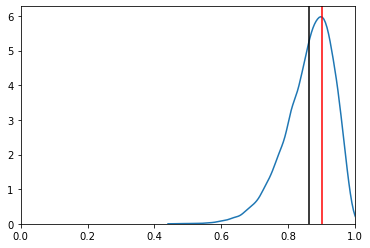

In [527]:
ax = sns.kdeplot(dist)
plt.axvline(0.9, 0,15, color='r')
plt.axvline(np.mean(dist), 0,15, color='black')
ax.set(xlim=(0,1))

Get final table from the last season. Get teams from this season which will be included in the next (simulated) season, and generate random season of fixtures for the new season using these teams, and add their final pointsPC values as the PPCprev values for the new season.

In [602]:
# last seasons finishing table
final_table_prev = all_seasons_WLD[all_seasons_WLD['Season']==24].copy()
# get list of teams to be included in the current season
teams = list(final_table_prev['Team'])

# sample 'PointsPCnew' from beta distribution with mode equal to 'PointsPC' value (adds random variation)
for team in teams:    
    alpha, beta = get_beta_coefs(final_table_prev.loc[final_table_prev['Team']==team, 'PointsPC'].item(), 0.0025)
    final_table_prev.loc[final_table_prev['Team']==team, 'PointsPCnew'] = np.random.beta(alpha, beta)

# update 'PointsPC' columns in the table     
final_table_prev['PointsPCold'] = final_table_prev['PointsPC']   
final_table_prev['PointsPC'] = final_table_prev['PointsPCnew']
final_table_prev['PointsPCnew'] = final_table_prev['PointsPC'] - final_table_prev['PointsPCold']

# call function to generate season of random fixtures for the given list of teams
newseason = generate_fixtures(teams)

# add columns for PPCprev, form and result and set to 0.0/'' for now
newseason['HomePPCprev'] = 0.0
newseason['AwayPPCprev'] = 0.0
newseason['HomeForm5'] = 0.0
newseason['AwayForm5'] = 0.0
newseason['SimResult'] = ''

# loop through all fixtures 
for fixture in range(newseason.shape[0]):
    newseason.loc[fixture,'HomePPCprev'] = final_table_prev[final_table_prev['Team']==newseason.loc[fixture,'HomeTeam']]['PointsPC'].item()
    newseason.loc[fixture,'AwayPPCprev'] = final_table_prev[final_table_prev['Team']==newseason.loc[fixture,'AwayTeam']]['PointsPC'].item()

In [603]:
final_table_prev

,Season,Team,W,D,L,PointsTot,PointsPC,PointsPCnew,PointsPCold
9,24,Liverpool,32,3,3,99,0.851522,-0.0168993,0.868421
10,24,Man City,26,3,9,81,0.737475,0.0269485,0.710526
11,24,Man United,18,12,8,66,0.526403,-0.0525445,0.578947
5,24,Chelsea,20,6,12,66,0.611703,0.0327559,0.578947
8,24,Leicester,18,8,12,62,0.505360,-0.0384993,0.54386
16,24,Tottenham,16,11,11,59,0.467270,-0.0502741,0.517544
19,24,Wolves,15,14,9,59,0.467342,-0.0502023,0.517544
0,24,Arsenal,14,14,10,56,0.550094,0.0588657,0.491228
4,24,Burnley,15,9,14,54,0.526410,0.052726,0.473684
14,24,Sheffield United,14,12,12,54,0.454256,-0.0194282,0.473684


Create tables to store final points, points achieved in each game and form at each game for the new simulated season.

In [604]:
# get list of unique teams in the current season
new_teams = sorted(list(set(newseason['HomeTeam'])))

# create dataframe with relevant columns, add teams as the 1st column
new_WLD_cols = ['W','D','L','PointsTot','PointsPC']
new_teams_WLD = DataFrame(columns=new_WLD_cols)
new_teams_WLD.insert(0,"Team",new_teams)
    
## create data frame to store points in each game
new_teams_ppg = DataFrame(columns=range(1,39))
new_teams_ppg.insert(0,"Team",new_teams)
## create data frame to store 5 game form
new_teams_form = DataFrame(columns=range(1,39))
new_teams_form.insert(0,"Team",new_teams)

Predict results of fixtures in a brand new season.

In [605]:
# create list of possible form values (integers from 0 to 15 but with 14 omitted)
form_classes = list(range(16))
form_classes.remove(14)

# loop through all the fixtures in the new season dataframe
for fixture in range(newseason.shape[0]):
    
    # get names of home and away teams
    hometeam = newseason.loc[fixture, 'HomeTeam']
    awayteam = newseason.loc[fixture, 'AwayTeam']
    # get next available game index values for the home and away teams
    home_nextfree = new_teams_form.columns[(new_teams_form.loc[new_teams_form['Team']==hometeam,].isna()).iloc[0]].min()
    away_nextfree = new_teams_form.columns[(new_teams_form.loc[new_teams_form['Team']==awayteam,].isna()).iloc[0]].min()
    
    # if gameweek <= 5 we will need to impute the form values for each team
    if newseason.loc[fixture, 'Gameweek'] <= form_games:
        # impute home form value based on HomePPCprev value (sampling from probabilities obtained from ordinal regression)
        newseason.loc[fixture, 'HomeForm5'] = np.random.choice(form_classes, 1, p=ord_reg_home.predict_proba(np.array(newseason.loc[fixture, 'HomePPCprev'])).flatten()).item()
        # add form value to next available game in new_teams_form dataframe
        new_teams_form.loc[new_teams_form['Team']==hometeam, home_nextfree] = newseason.loc[fixture, 'HomeForm5']
        
        # impute away form value based on AwayPPCprev value (sampling from probabilities obtained from ordinal regression)
        newseason.loc[fixture, 'AwayForm5'] = np.random.choice(form_classes, 1, p=ord_reg_home.predict_proba(np.array(newseason.loc[fixture, 'AwayPPCprev'])).flatten()).item()
        # add form value to next available game in new_teams_form dataframe
        new_teams_form.loc[new_teams_form['Team']==awayteam, away_nextfree] = newseason.loc[fixture, 'AwayForm5']
        
    # else, obtain form value from the form table
    else:
        # calculate form of home team (points in the last 5 games)
        home_form5 = (new_teams_ppg[new_teams_ppg['Team']==hometeam]).iloc[:,(home_nextfree-form_games):(home_nextfree)].values.sum()
        # add form value to HomeForm5 column for the current fixture
        newseason.at[fixture, 'HomeForm5'] = home_form5
        # add form value to new_teams_form dataframe
        new_teams_form.loc[new_teams_form['Team']==hometeam, home_nextfree] = home_form5
            
        # calculate form of away team (points in the last 5 games)
        away_form5 = (new_teams_ppg[new_teams_ppg['Team']==awayteam]).iloc[:,(away_nextfree-form_games):(away_nextfree)].values.sum()
        # add form value to AwayForm5 column for the current fixture
        newseason.at[fixture, 'AwayForm5'] = away_form5
        # add form value to new_teams_form dataframe
        new_teams_form.loc[new_teams_form['Team']==awayteam, away_nextfree] = away_form5
        
    # get predicted probabilities for a home win, draw and away win for the current fixture
    FTRprobs = list(mymodel.predict_proba(np.array(list(newseason.loc[fixture,['HomePPCprev', 'AwayPPCprev', 'HomeForm5', 'AwayForm5']])).reshape(1, -1)).flatten())
    # sample full time result for the current fixture based off the probabilities
    result = np.random.choice(mymodel.classes_, 1, p=FTRprobs)[0]
    # add simulated result to SimResult column for the current fixture
    newseason.at[fixture, 'SimResult'] = result
    
    # add points (based on simulated result) to new_teams_ppg dataframe for home and away teams
    if result == 'H':
        new_teams_ppg.loc[new_teams_ppg['Team']==hometeam, home_nextfree] = 3.0
        new_teams_ppg.loc[new_teams_ppg['Team']==awayteam, away_nextfree] = 0.0
    elif result == 'A':
        new_teams_ppg.loc[new_teams_ppg['Team']==hometeam, home_nextfree] = 0.0
        new_teams_ppg.loc[new_teams_ppg['Team']==awayteam, away_nextfree] = 3.0
    else:
        new_teams_ppg.loc[new_teams_ppg['Team']==hometeam, home_nextfree] = 1.0
        new_teams_ppg.loc[new_teams_ppg['Team']==awayteam, away_nextfree] = 1.0

In [606]:
# loop through all teams in the current season
for team in new_teams:
    # count total no. of wins/losses/draws for each team in the current season
    Ws = sum(((newseason["HomeTeam"]==team) & (newseason["SimResult"]=='H')) | ((newseason["AwayTeam"]==team) & (newseason["SimResult"]=='A')))
    Ds = sum(((newseason["HomeTeam"]==team) | (newseason["AwayTeam"]==team)) & (newseason["SimResult"]=='D'))
    Ls = sum(((newseason["HomeTeam"]==team) & (newseason["SimResult"]=='A')) | ((newseason["AwayTeam"]==team) & (newseason["SimResult"]=='H')))
    # count total number of points and % of overall points for each team
    Points = 3*Ws + 1*Ds
    PointsPC = Points / (38*3)
    # add season stats for current team to the dataframe
    new_teams_WLD.loc[new_teams_WLD['Team']==team, new_WLD_cols] = [Ws, Ds, Ls, Points, PointsPC]
        
# sort by highest points
new_teams_WLD = new_teams_WLD.sort_values('PointsTot', ascending=False)

In [607]:
# new simulated season
display(new_teams_WLD)
# last season
display(final_table_prev[['Team','W','D','L','PointsTot','PointsPCold','PointsPC']])

,Team,W,D,L,PointsTot,PointsPC
9,Liverpool,32,2,4,98,0.859649
10,Man City,24,7,7,79,0.692982
15,Southampton,19,11,8,68,0.596491
18,West Ham,16,9,13,57,0.5
5,Chelsea,15,11,12,56,0.491228
8,Leicester,14,13,11,55,0.482456
14,Sheffield United,15,10,13,55,0.482456
0,Arsenal,13,14,11,53,0.464912
2,Bournemouth,14,11,13,53,0.464912
12,Newcastle,13,11,14,50,0.438596


,Team,W,D,L,PointsTot,PointsPCold,PointsPC
9,Liverpool,32,3,3,99,0.868421,0.851522
10,Man City,26,3,9,81,0.710526,0.737475
11,Man United,18,12,8,66,0.578947,0.526403
5,Chelsea,20,6,12,66,0.578947,0.611703
8,Leicester,18,8,12,62,0.54386,0.505360
16,Tottenham,16,11,11,59,0.517544,0.467270
19,Wolves,15,14,9,59,0.517544,0.467342
0,Arsenal,14,14,10,56,0.491228,0.550094
4,Burnley,15,9,14,54,0.473684,0.526410
14,Sheffield United,14,12,12,54,0.473684,0.454256


In order to add variation into the system which will aid to account for major changes that happen to teams between seasons (e.g. team sign a player that improves the team significantly, or a key player is injured and the team aren't as strong as in the previous year), the HomePPCprev and AwayPPCprev can also be randomly sampled. A Beta distribution is suitable in this case as it is bounded between 0 and 1 as is required.

In order to sample a PPCprev value for an individual team, we can randomly sample the value from a Beta distribution with a specified variance and with its mode (or median) equal to the actual PPCprev value obtained by the team. The mode is preferred to the mean as the beta distribution tends to be skewed significantly when its mean is close to 0 or close to 1. In such cases the the median or mode can be a better measure of the centre of the distribution.

Using the mode instead of the median will also reduce the likelihood of teams that achieved an unusually high points total from getting an even larger PPCprev value after sampling from the beta distribution (and likewise for teams that achieved an unusually low number of points).

To calculate the $\alpha$ and $\beta$ parameter values for a Beta distribution with a specified mode and variance, we can use the following equations:

$Mode[X] = \frac{\alpha - 1}{\alpha + \beta - 2}$

$Var[X] = \frac{\alpha \beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}$

Note that this definition of the mode is valid obly when $\alpha$ and $\beta$ in our Beta function are both be greater than 1, which will be the case here.

We can solve for $\alpha$ and $\beta$ in terms of Mode[X] and Var[X], where:

$\beta = (\frac{1 - Mode[X]}{Mode[X]}) \alpha + (\frac{2 Mode[X] - 1}{Mode[X]}) = x \alpha + y$ ........ (i.e. $x = \frac{1 - Mode[X]}{Mode[X]}$ and $y = \frac{2 Mode[X] - 1}{Mode[X]}$)

and where $\alpha$ is obtained by getting the roots of the following cubic equation, and finding the root that is greater than 1 (as this is a constraint of our Beta distribution in this case):

$\alpha ^3 (x^3 + 3x^2 + 3x + 1) + 
\alpha ^2 (x^2 + 2x + 3y + 3x^2y + 6xy + 1 - \frac{x}{Var[X]}) + 
\alpha (3y^2 + 2y + 3xy^2 + 2xy - \frac{y}{Var[X]}) + 
(y^3 + y^2) = 0$  



In [140]:
# function calculates coefficients for claculating alpha for Beta distribution with specified Mode and Var
def get_beta_coefs(Mode, Var):
    # define x and y to simplify equation
    x = (1 - Mode)/Mode
    y = (2*Mode - 1)/Mode
    # calculate coefficients of cubic equation to solve for alpha value
    a =  (x**3) + 3*(x**2) + 3*x + 1
    b =  (x**2) + 2*x + 3*y + 3*(x**2)*y + 6*x*y + 1 - x/Var
    c =  3*(y**2) + 2*y + 3*x*(y**2) + 2*x*y - y/Var
    d =  (y**3) + (y**2)
    
    # get roots of the cubic equation
    roots = np.roots([a,b,c,d])
    
    # check if a root exists that is >1
    if len(roots[roots>1]) > 0:
        # set alpha to value of the root that is >1
        alpha = roots[roots>1].item()
        # set beta based on alpha
        beta = x * alpha + y
    else:
        # if no root >1, print message to reduce variance
        print("No roots greater than 1 (reduce variance value)")
        alpha = np.nan
        beta = np.nan
        
    return alpha, beta

In [902]:
aaa,bbb = get_beta_coefs(0.9,0.005)
aaa,bbb

(19.403240015170134, 3.0448044461300143)

In [903]:
dist = np.random.beta(aaa,bbb, size=10000)

[(0.0, 1.0)]

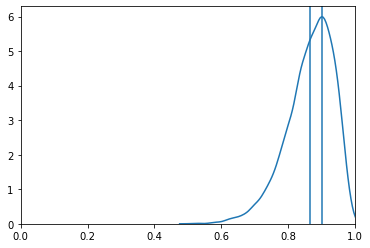

In [905]:
ax = sns.kdeplot(dist)
plt.axvline(0.9, 0,15)
plt.axvline(np.mean(dist), 0,15)
ax.set(xlim=(0,1))

In [52]:
 # function to get class. accuracy for predicted classes
def preds_class_acc(preds, valy):
    # create confusion matrix of actual classes vs predicted classes
    tab = metrics.confusion_matrix(valy, preds)
    # return classification accuracy
    return tab.diagonal().sum()/tab.sum()

# function to get class. accuracy for classes sampled from probabilities
def probs_class_acc(model, probs_mod, num_runs, valy):
    # create vector of 0s
    class_acc_vec = [0] * num_runs
    
    # run through for loop for the number of runs specified
    for run in range(num_runs):
        # create empty vector to store sampled class values (string type)
        mypreds = [""] * probs_mod.shape[0]
        
        # loop through each row of the class probabilities matrix
        for i in range(probs_mod.shape[0]):
            # sample the class using the associated class probabilities
            mypreds[i] = random.choices(model.classes_, probs_mod[i,:], k=1)[0]

        # get class. accuracy for the current sampled classes
        class_acc_vec[run] = preds_class_acc(valy, mypreds)
    # return mean value of class accuracy from all runs
    return np.mean(class_acc_vec)

# function combines all functions above to fit model, predict classes and get class
# probabilities, and calculate class. accuracy values for predicted and sampled classes
def fit_preds_probs(model, trainx, trainy, valx, valy, num_runs):
    # predict classes and get class probabilities for validation data
    model, preds_mod, probs_mod = model_fit_predict(model, trainx, trainy, valx)
    # get class. accuracy for the validation data using predicted classes
    class_acc_pred = preds_class_acc(preds_mod, valy)
    # get class. accuracy for the validation data using sampled classes
    class_acc_prob = probs_class_acc(model, probs_mod, num_runs, valy)
    # return class. accuracy values 
    return class_acc_pred, class_acc_prob

In [457]:
num_folds = 10
folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

preds_vec_lda = [0] * num_folds
predsrand_vec_lda = [0] * num_folds
preds_vec_rf = [0] * num_folds
predsrand_vec_rf = [0] * num_folds
preds_vec_boost = [0] * num_folds
predsrand_vec_boost = [0] * num_folds
preds_vec_boost2 = [0] * num_folds
predsrand_vec_boost2 = [0] * num_folds
preds_vec_knn = [0] * num_folds
predsrand_vec_knn = [0] * num_folds
#preds_vec_svm = [0] * num_folds
#predsrand_vec_svm = [0] * num_folds
#preds_vec_svm2 = [0] * num_folds
#predsrand_vec_svm2 = [0] * num_folds

for k in range(num_folds):
    # use current fold as the current validation set
    val_fold = folds[k]
    val_x = val_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    val_y = val_fold['FTR'].values
    
    # combine remaining folds to use as current training set
    train_ind_list = list(range(num_folds))
    train_ind_list.remove(k)
    train_fold = pd.concat([folds[i] for i in train_ind_list])
    train_x = train_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    train_y = train_fold['FTR'].values
    
    ### LDA ###
    # create LDA model
    lda_mod = lda()
    # get class. accuracy for the validation data using predicted classes and sampled classes
    preds_vec_lda[k], predsrand_vec_lda[k] = fit_preds_probs(lda_mod, train_x, train_y, val_x, val_y, 100)
        
    ### Random Forest ###
    # create random forest model
    rf_mod = rf(random_state=0)   
    # get class. accuracy for the validation data using predicted classes and sampled classes
    preds_vec_rf[k], predsrand_vec_rf[k] = fit_preds_probs(rf_mod, train_x, train_y, val_x, val_y, 100)
       
    ### Boosting ###
    # create boosting model
    boost_mod = boost(random_state=0)
    # get class. accuracy for the validation data using predicted classes and sampled classes
    preds_vec_boost[k], predsrand_vec_boost[k] = fit_preds_probs(boost_mod, train_x, train_y, val_x, val_y, 100)
    
    ### KNN ###
    # create knn model
    knn_mod = knn(n_neighbors=20)
    # get class. accuracy for the validation data using predicted classes and sampled classes
    preds_vec_knn[k], predsrand_vec_knn[k] = fit_preds_probs(knn_mod, train_x, train_y, val_x, val_y, 100)
    
    print(k)

0
1
2
3
4
5
6
7
8
9


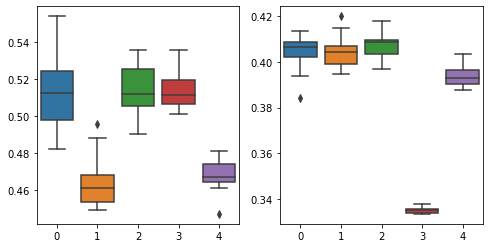

In [458]:
# set up plot size
plt.figure(figsize=(8,4))

# plot boxplots
ax1 = plt.subplot(121)
plot1 = sns.boxplot(data = [preds_vec, preds_vec_rf, preds_vec_boost, preds_vec_boost2, preds_vec_knn])
ax2 = plt.subplot(122)
plot2 = sns.boxplot(data = [predsrand_vec, predsrand_vec_rf, predsrand_vec_boost, predsrand_vec_boost2, predsrand_vec_knn])

In [543]:
num_folds = 10
num_models = 16

rf_params = np.array([[200, 6], [400, 6], [600, 6], [800, 6],
         [200, 7], [400, 7], [600, 7], [800, 7],
         [200, 9], [400, 9], [600, 9], [800, 9],
         [200, 11], [400, 11], [600, 11], [800, 11]])

folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

rf_pred_array = np.zeros(shape=[num_folds,num_models])
rf_prob_array = np.zeros(shape=[num_folds,num_models])


for k in range(num_folds):
    # use current fold as the current validation set
    val_fold = folds[k]
    val_x = val_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    val_y = val_fold['FTR'].values
    
    # combine remaining folds to use as current training set
    train_ind_list = list(range(num_folds))
    train_ind_list.remove(k)
    train_fold = pd.concat([folds[i] for i in train_ind_list])
    train_x = train_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    train_y = train_fold['FTR'].values
    
    ### Random Forest ###
    # create random forest model
    for j in range(num_models):
        rf_mod = rf(n_estimators=rf_params[j,0], max_depth=rf_params[j,1], random_state=0)
        rf_pred_array[k,j], rf_prob_array[k,j] = fit_preds_probs(rf_mod, train_x, train_y, val_x, val_y, 100)
    
    print(k)

0
1
2
3
4
5
6
7
8
9


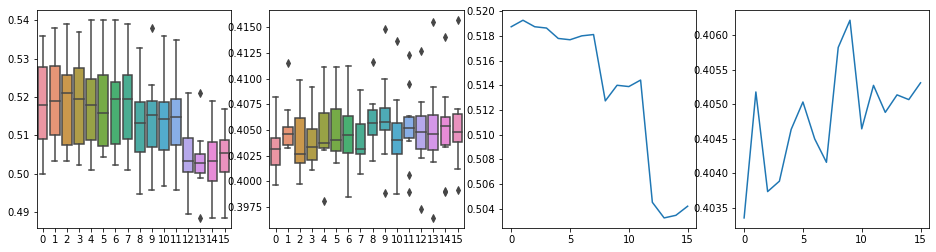

In [544]:
# set up plot size
plt.figure(figsize=(16,4))

# plot boxplots
ax1 = plt.subplot(141)
plot1 = sns.boxplot(data=rf_pred_array)
ax2 = plt.subplot(142)
plot2 = sns.boxplot(data=rf_prob_array)
# plot mean values
ax3 = plt.subplot(143)
plot3 = plt.plot(np.mean(rf_pred_array, axis=0))
ax4 = plt.subplot(144)
plot4 = plt.plot(np.mean(rf_prob_array, axis=0))